In [1]:
import time
import os
import sys

import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats
import matplotlib.pyplot as plt
import projplot.proj_plot as pjp
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set()

import jax
import jax.numpy as jnp
import jax.random as random

import pfjax as pf
from pfjax import particle_resamplers as resampler
from pfjax.models import BMModel
from pfjax.experimental.models import LotVolModelLog
import optax
from jax import lax
from functools import partial

import warnings
warnings.filterwarnings('ignore')

# again, this only works on startup!
from jax.config import config
config.update("jax_enable_x64", True)

In [2]:
from pfjax.utils import lwgt_to_prob, continuous_cdf, interpolate_weights, argsort_marginal

# LotVo Model

In [3]:
# parameter values
alpha = 1.0
beta = 1.0
gamma = 4.0
delta = 1.0
sigma_h = 0.1
sigma_l = 0.1
tau_h = 0.25
tau_l = 0.25

theta = np.array([alpha, beta, gamma, delta, sigma_h, sigma_l, tau_h, tau_l])
theta_names = ["alpha", "beta", "gamma", "delta",
               "sigma_h", "sigma_l", "tau_h", "tau_l"]
theta_lims = np.array(list(zip(theta - (theta/2), theta + (theta/2))))

dt = 0.1
n_res = 1
n_obs = 100

_key = random.PRNGKey(0)
_key, _subkey = random.split(_key)

In [4]:
lotvol_model = LotVolModelLog(dt, n_res, bootstrap = True) 
theta = jnp.log(theta)

x_init = jnp.block([[jnp.zeros((n_res-1, 2))],
                    [jnp.log(jnp.array([5., 3.]))]])

y_meas, x_state = pf.simulate(model = lotvol_model, 
                              n_obs = n_obs, 
                              x_init = x_init, 
                              theta = theta, 
                              key = _subkey)

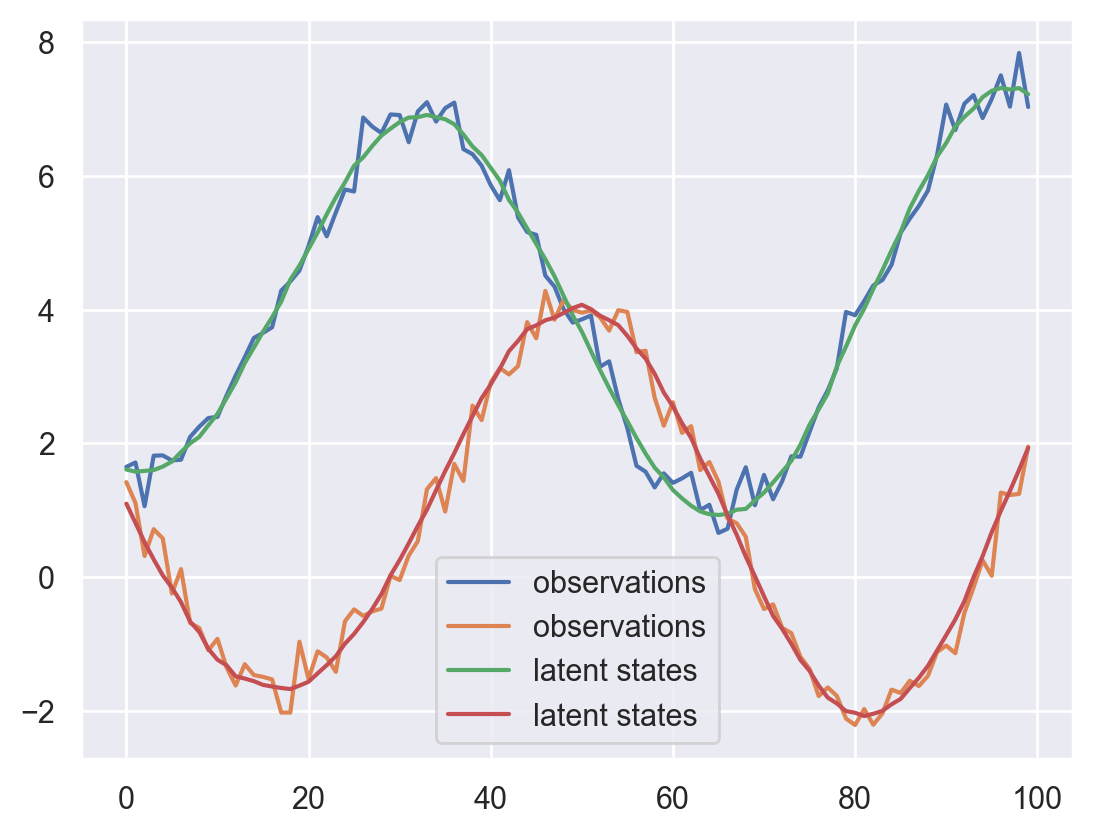

In [5]:
plt.plot(y_meas, label = "observations");
plt.plot(x_state.squeeze(), label = "latent states")
plt.legend();

In [6]:
theta_lims = jnp.log(jnp.array([
    [0.8, 1.2],
    [0.9, 1.1],
    [3.8, 4.2],
    [0.95, 1.05],
    [0.05, 0.2],
    [0.01, 0.2],
    [0.1, 0.4],
    [0.1, 0.4]]))

# theta_lims = jnp.log(jnp.array([
#     [0.95, 1.05],
#     [0.95, 1.05],
#     [3.95, 4.05],
#     [0.95, 1.05],
#     [0.05, 0.15],
#     [0.05, 0.15],
#     [0.2, 0.3],
#     [0.2, 0.3]]))

In [7]:
@partial(jax.jit, static_argnums=(2,3))
def lotvol_neg_loglik(theta, key, resampler = resampler.resample_mvn, n_particles=100):
    """
    Negative log-likelihood for lotka volterra model (lotvol_model)
    """
    temp = pf.particle_filter(
        theta=theta, 
        model=lotvol_model, 
        y_meas=y_meas, 
        n_particles=n_particles, 
        key=key,
        resampler = resampler)
    return -temp["loglik"]


@partial(jax.jit, static_argnums=(2,))
def particle_neg_loglik_mvn(theta, key, n_particles=500):
    """ negative log-likelihood of PF with MVN resampling """
    ret = pf.particle_filter(
        theta=theta, 
        model=lotvol_model, 
        y_meas=y_meas, 
        n_particles=n_particles, 
        key=key,
        resampler = resampler.resample_mvn)
    return -ret["loglik"]


@partial(jax.jit, static_argnums=(2,))
def particle_neg_loglik_gc(theta, key, n_particles=250):
    """ negative log-likelihood of PF with GC resampling """
    ret = pf.particle_filter(
        theta=theta, 
        model=lotvol_model, 
        y_meas=y_meas, 
        n_particles=n_particles, 
        key=key,
        resampler = resampler.resample_gaussian_copula)
    return -ret["loglik"]


@partial(jax.jit, static_argnums=(2,))
def particle_neg_loglik_bootstrap(theta, key, n_particles=500):
    """ negative log-likelihood of PF with multinomial resampling """
    ret = pf.particle_filter(
        theta=theta, 
        model=lotvol_model, 
        y_meas=y_meas, 
        n_particles=n_particles, 
        key=key)
    return -ret["loglik"]

In [8]:
gc_ll = particle_neg_loglik_gc(theta, key=_key)
print("GC: ", gc_ll)

mvn_ll = particle_neg_loglik_mvn(theta, key=_key)
print("MVN: ", mvn_ll)

bootstrap_ll = particle_neg_loglik_bootstrap(theta, key=_key)
print("Bootstrap: ", bootstrap_ll)

GC:  23.737898274221607
MVN:  24.483298952102587
Bootstrap:  25.633663250600648


In [ ]:
# calculate projection plot for exact loglikelihood
df_gc = pjp.proj_plot(
    fun = lambda x: particle_neg_loglik_gc(x, key=_key, n_particles=300), 
    x_opt=theta, 
    x_lims=theta_lims, 
    x_names=theta_names, 
    n_pts=100,
    plot=False
)


# calculate projection plot for exact loglikelihood
df_mvn = pjp.proj_plot(
    fun = lambda x: particle_neg_loglik_mvn(x, key=_key, n_particles=300), 
    x_opt=theta, 
    x_lims=theta_lims, 
    x_names=theta_names, 
    n_pts=100,
    plot=False
)

# calculate projection plot for particle filter loglikelihood
df_multinom = pjp.proj_plot(
    fun=lambda x: particle_neg_loglik_bootstrap(x, key=_key, n_particles=300),
    x_opt=theta, 
    x_lims=theta_lims, 
    x_names=theta_names, 
    n_pts=100,
    plot=False
)

In [ ]:
# merge data frames and plot them
plot_df = pd.concat([df_gc, df_multinom, df_mvn], ignore_index=True)
plot_df["Resampler"] = np.repeat(["Gaussian Copula", "Multinomial", "MVN"], len(df_gc["x_opt"]))
plot_df = plot_df.rename(columns={"y": "neg-loglikelihood"})

# plot_df = plot_df[plot_df.x_opt.isin(["alpha", "beta"])]

grid = sns.relplot(
    data=plot_df, #[plot_df.x_opt.isin(["alpha", "beta"])], 
    kind="scatter",
    x="x", y="neg-loglikelihood", 
    hue="Resampler",
    col="x_opt",
    col_wrap = 4,
    facet_kws=dict(sharex=False, sharey=False)
)
grid.set_titles(col_template="{col_name}")
grid.set(xlabel=None);

for ind, _ax in enumerate(grid.axes.flat):
    _ax.axvline(theta[ind], color='red', lw = 0.9, label="True")
    _ax.legend();

## Check Score Function

In [27]:
# various score functions
@partial(jax.jit, static_argnums=(2,))
def lotvol_score_autograd(theta, key, n_particles):
    return jax.grad(lotvol_neg_loglik)(theta, key, n_particles=n_particles)


@partial(jax.jit, static_argnums=(2,))
def lotvol_score_acc(theta, key, n_particles):
    out = pfex.particle_filter(
        model=lotvol_model,
        key=key,
        y_meas=y_meas,
        theta=theta,
        n_particles=n_particles,
        score=True,
        fisher=False,
        history=False
    )
    return out["score"]


@partial(jax.jit, static_argnums=(2,))
def lotvol_score_rb(theta, key, n_particles): 
    out = pfex.particle_filter_rb(
        model=lotvol_model,
        key=key,
        y_meas=y_meas,
        theta=theta,
        n_particles=n_particles,
        score=True,
        fisher=False,
        history=False
    )
    return out["score"]


# @partial(jax.jit, static_argnums=(2,))
# def lotvol_score_gc(theta, key, n_particles): 
#     out = pfex.particle_filter_rb(
#         model=lotvol_model,
#         key=key,
#         y_meas=y_meas,
#         theta=theta,
#         resampler = resampler.resample_gaussian_copula,
#         n_particles=n_particles,
#         score=True,
#         fisher=False,
#         history=False
#     )
#     return out["score"]

In [31]:
key = random.PRNGKey(0)
n_particles_stan = 2500
n_particles_rb = 100
n_sim = 100
n_particles_cont = 500
key, *subkeys = random.split(key, n_sim+1)

# check timings
%timeit lotvol_score_autograd(theta, key, n_particles_stan)
%timeit lotvol_score_acc(theta, key, n_particles_stan)
%timeit lotvol_score_rb(theta, key, n_particles_rb)
# %timeit bm_score_cont(theta, key, n_particles_cont)

197 ms ± 15.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
124 ms ± 5.28 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


AttributeError: 'LotVolModelLog' object has no attribute 'step_sample'

In [ ]:
# repeat calculation nsim times
score_auto = []
score_acc = []
score_rb = []
score_cont = []

for i in range(n_sim):
    score_auto += [lotvol_score_autograd(theta, subkeys[i], n_particles_stan)]
    score_acc += [lotvol_score_acc(theta, subkeys[i], n_particles_stan)]
    score_rb += [lotvol_score_rb(theta, subkeys[i], n_particles_rb)]
#     score_cont += [bm_score_cont(theta, subkeys[i], n_particles_cont)]

In [ ]:
plot_df = (
    pd.DataFrame({
    "theta": np.tile(theta_names, n_sim),
    "auto": np.array(score_auto).ravel(),
    "acc": np.array(score_acc).ravel(),
    "rb": np.array(score_rb).ravel(),
    "cont": np.array(score_cont).ravel()
})
    .melt(id_vars=["theta"], value_vars=["auto", "acc", "rb", "cont"], var_name="method")
)

g = sns.catplot(
    data=plot_df, kind="box",
    x="method", y="value",
    col="theta",
    col_wrap=3,
    sharey=False
);

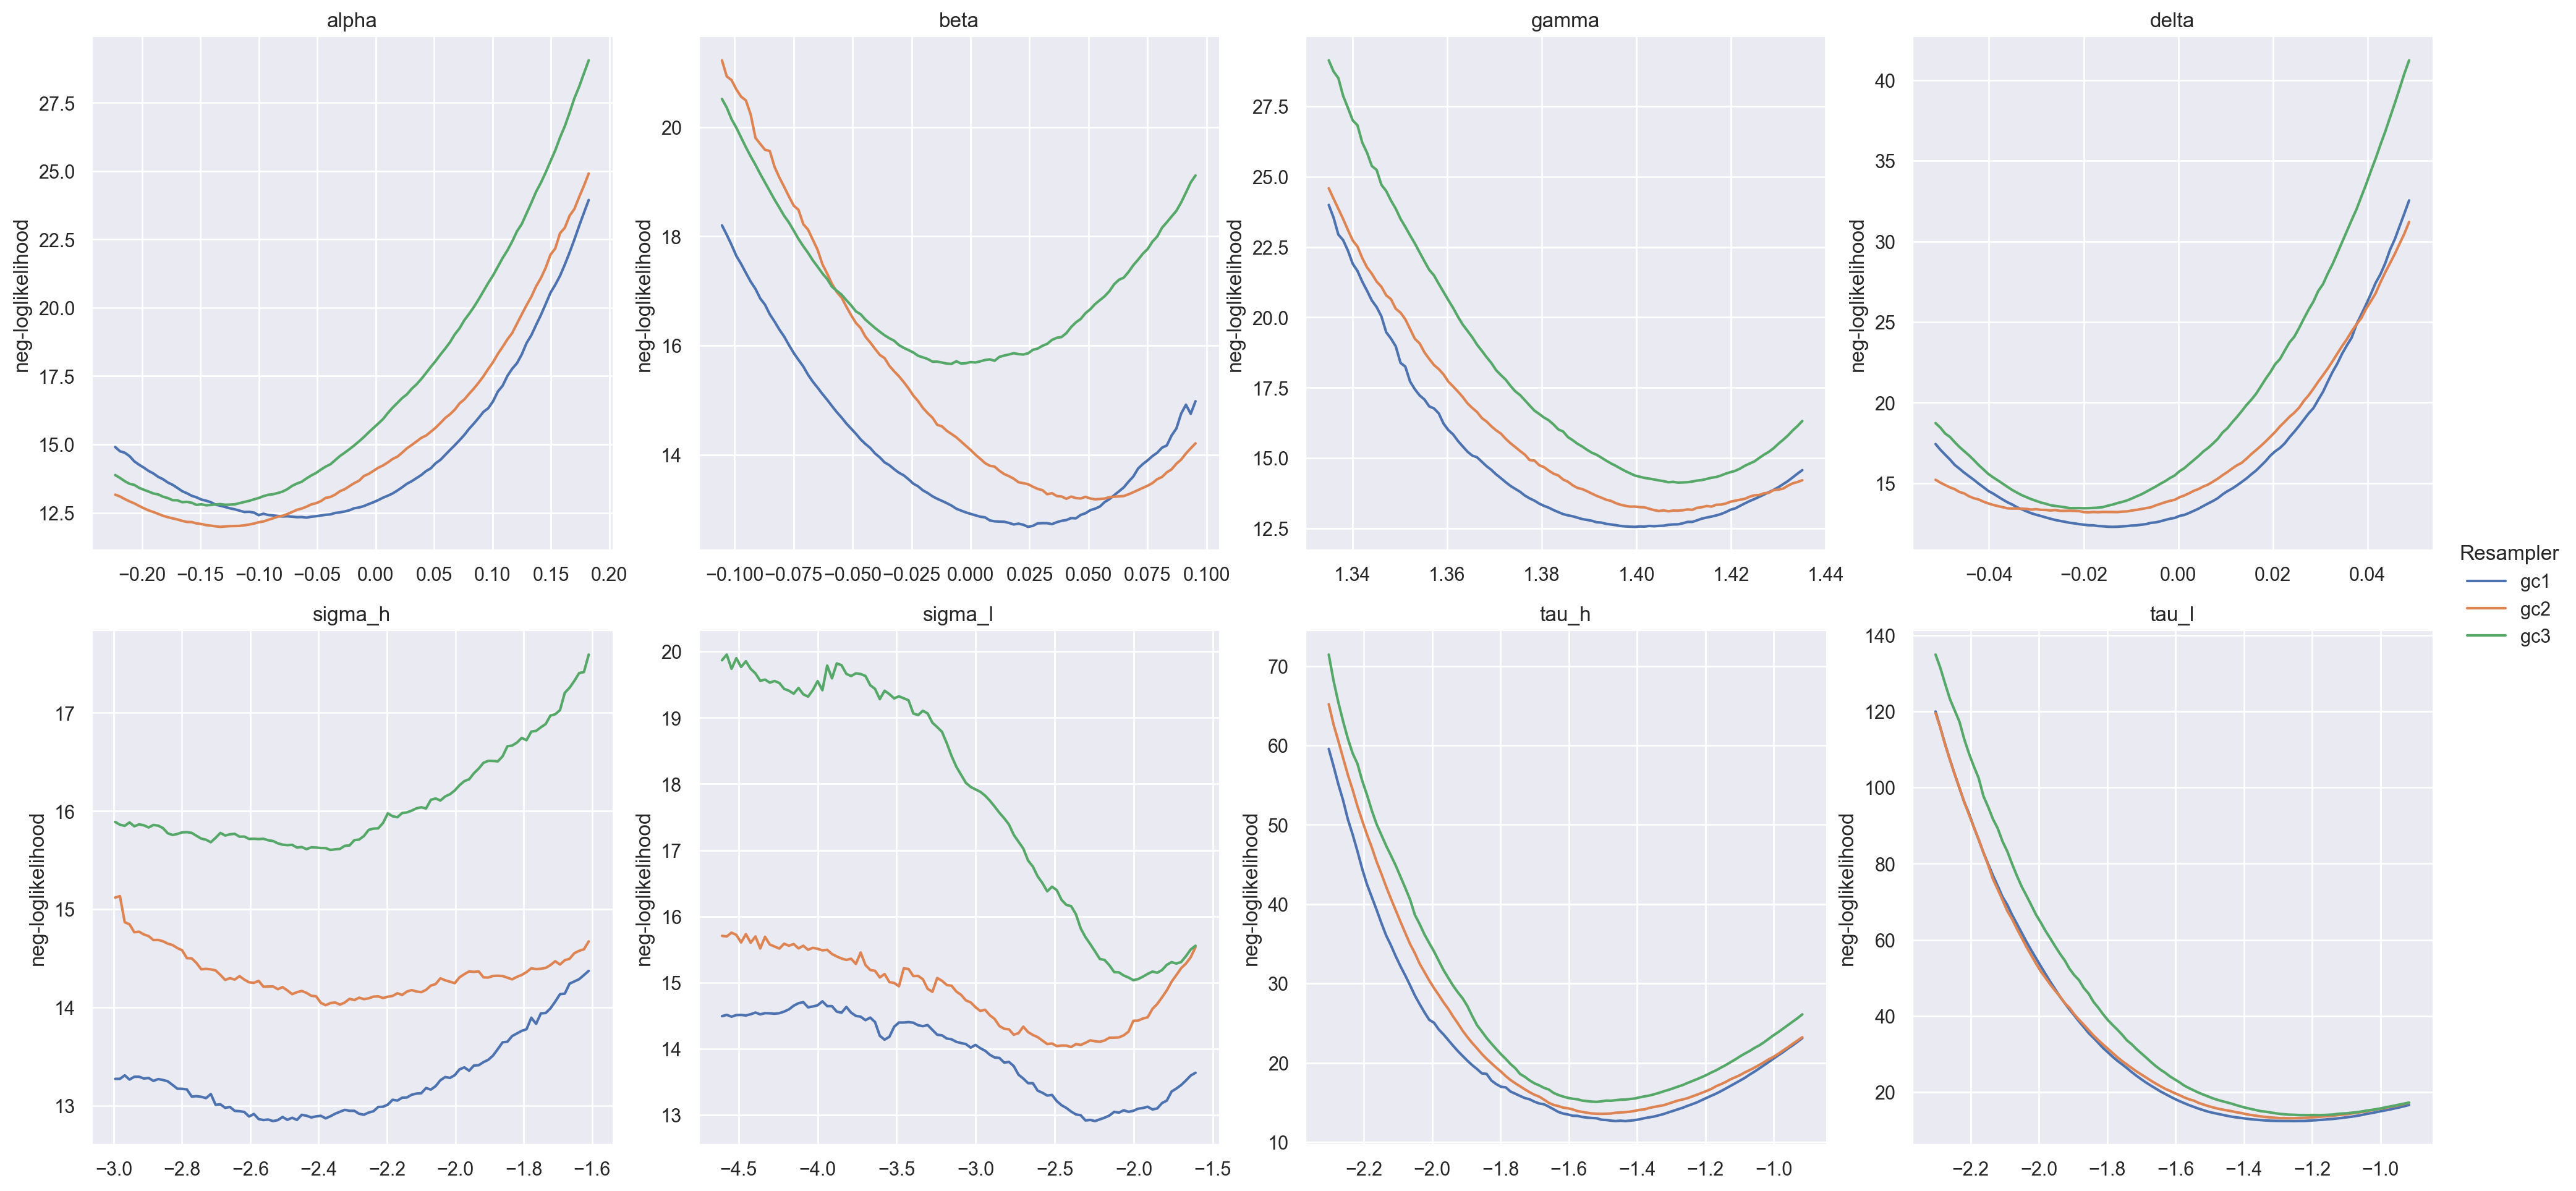

In [10]:
# GC projection plots for different keys
# Goal: Is the log-likelihood the same for different keys or does it change? If it does change, we will need 
# to run gradient descent for the same key (i.e. don't update the key at every update step)

_, *subkeys = random.split(_key, 4)

df_gc1 = pjp.proj_plot(
    fun = lambda x: particle_neg_loglik_gc(x, key=jnp.array(subkeys[0]), n_particles=100), 
    x_opt=theta, 
    x_lims=theta_lims, 
    x_names=theta_names, 
    n_pts=100,
    plot=False
)

# calculate projection plot for exact loglikelihood
df_gc2 = pjp.proj_plot(
    fun = lambda x: particle_neg_loglik_gc(x, key=jnp.array(subkeys[1]), n_particles=100), 
    x_opt=theta, 
    x_lims=theta_lims, 
    x_names=theta_names, 
    n_pts=100,
    plot=False
)

# calculate projection plot for exact loglikelihood
df_gc3 = pjp.proj_plot(
    fun = lambda x: particle_neg_loglik_gc(x, key=jnp.array(subkeys[2]), n_particles=100), 
    x_opt=theta, 
    x_lims=theta_lims, 
    x_names=theta_names, 
    n_pts=100,
    plot=False
)


# merge data frames and plot them
_df = pd.concat([df_gc1, df_gc2, df_gc3], ignore_index=True)
_df["Resampler"] = np.repeat(["gc1", "gc2", "gc3"], len(df_gc1["x_opt"]))
_df = _df.rename(columns={"y": "neg-loglikelihood"})

grid = sns.relplot(
    data=_df, kind="line",
    x="x", y="neg-loglikelihood", 
    hue="Resampler",
    col="x_opt",
    col_wrap = 4,
    facet_kws=dict(sharex=False, sharey=False)
)
grid.set_titles(col_template="{col_name}")
grid.set(xlabel=None);

# Stochastic Optimization 

**TODO:**
- [x] Use bridge proposal 
- [ ] Include optimal transport resampling in plots
- [ ] Work precision plots:
    - Benchmark: Take true params and 5k particles (lots of particles)
    - Run basic pf with a diff number of particles with diff seeds each time
    - Evaluate the log-lik on each of these particles 100 times each (multiple times each)
    - Record the runtime per random seed, for each of the number of particles
    - Calculate RMSE for each of the true params and estimated params for each # of particles
    - Plot (clock time VS accuracy) for each method. Doesn't have to be the same number of particle for each method, 

In [10]:
@partial(jax.jit, static_argnums=(3, 4, ))
def particle_neg_loglik_mvn(theta, key, y_meas, n_particles=500, model=lotvol_model):
    """ negative log-likelihood of PF with MVN resampling """
    ret = pf.particle_filter(
        theta=theta, 
        model=model, 
        y_meas=y_meas, 
        n_particles=n_particles, 
        key=key,
        resampler = resampler.resample_mvn)
    return -ret["loglik"]


@partial(jax.jit, static_argnums=(3, 4, ))
def particle_neg_loglik_gc(theta, key, y_meas, n_particles=500, model=lotvol_model):
    """ negative log-likelihood of PF with GC resampling """
    ret = pf.particle_filter(
        theta=theta, 
        model=model, 
        y_meas=y_meas, 
        n_particles=n_particles, 
        key=key,
        resampler = resampler.resample_gaussian_copula)
    return -ret["loglik"]


@partial(jax.jit, static_argnums=(3, 4, ))
def particle_neg_loglik_bootstrap(theta, key, y_meas, n_particles=500, model=lotvol_model):
    """ negative log-likelihood of PF with multinomial resampling """
    ret = pf.particle_filter(
        theta=theta, 
        model=model, 
        y_meas=y_meas, 
        n_particles=n_particles, 
        key=key)
    return -ret["loglik"]

In [11]:
%%timeit
bootstrap_ll = particle_neg_loglik_bootstrap(theta, _key, y_meas)

16.2 ms ± 274 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [12]:
%%timeit
mvn_ll = particle_neg_loglik_mvn(theta, _key, y_meas)

19.2 ms ± 565 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [13]:
%%timeit
gc_ll = particle_neg_loglik_gc(theta, _key, y_meas)

268 ms ± 2.95 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [14]:
import time

def update_params(params, subkey, opt_state, grad_fun=None, n_particles=100, 
                  y_meas=None, model=None, learning_rate=0.01, mask=None,
                  optimizer=None):
    loglik_value, params_update = jax.value_and_grad(grad_fun, argnums=0)(
        params, key=subkey, n_particles=n_particles, y_meas=y_meas, model=model)
    params_update = jnp.where(mask, params_update, 0)
    updates, opt_state = optimizer.update(params_update, opt_state)
    return optax.apply_updates(params, updates), loglik_value


def simple_grad_descent (subkey, model, theta, grad_fun, y_meas, n_particles=100, 
                         n_iter=10, learning_rate=0.01, mask=None):
    """ Deterministic optimization """
    optimizer = optax.adam(learning_rate) 
    opt_state = optimizer.init(theta)
    partial_update_params = partial(update_params, n_particles=n_particles, y_meas=y_meas,
                                    model=model, learning_rate=learning_rate, mask=mask, 
                                    grad_fun=grad_fun, optimizer=optimizer)
    update_fn = jax.jit(partial_update_params, donate_argnums=(0,))
    losses = []
    thetas = []
    times = []
    _start = time.time()
    for i in range(n_iter):
        # get value of loss function to make sure we are minimizing 
        start_time = time.perf_counter()
        theta, loglik_value = update_fn(theta, subkey, opt_state)
        times.append(time.perf_counter() - start_time)
        losses.append(loglik_value)
        thetas.append(theta)
    return theta, losses, thetas, times


def grad_descent_scan (key, model, theta, grad_fun, y_meas, n_particles=100, 
                       n_iter=10, learning_rate=0.01, mask=None):
    """ Deterministic optimization """
    _start = time.perf_counter()
    optimizer = optax.adam(learning_rate) 
    opt_state = optimizer.init(theta)
    partial_update_params = partial(update_params, n_particles=n_particles, y_meas=y_meas,
                                    model=model, learning_rate=learning_rate, mask=mask, 
                                    grad_fun=grad_fun, optimizer=optimizer)
    update_fn = jax.jit(partial_update_params, donate_argnums=(0,))

    def scan_fn (carry, i):
        _key, _subkey = random.split(carry["key"])
        theta, loglik_val = update_fn(carry["theta"], _subkey, carry["opt_state"])
        res = {
            "theta": theta,
            "losses": loglik_val}
        return {
            "key": _key,
            "theta": theta,
            "opt_state": opt_state}, res
    
    init_carry = {
        "key": key,
        "theta": init_params,
        "opt_state": opt_state
    }
    carry, res = lax.scan(scan_fn, init_carry, jnp.arange(n_iter))
    
    return {
        "theta": res["theta"][-1],
        "best_theta": res["theta"][jnp.argmin(res["losses"])],
        "steps": res["theta"],
        "losses": res["losses"]}

In [23]:
init_params = theta #jnp.log(jnp.array([1.1, .9, 3.5, 1.2, 0.1 , 0.1 , 0.25, 0.25])) # true params

# params from multinom filter w/ 10k particles
init_params = jnp.array([-2.00002353e-03, -3.59999848e-02,  1.38029436e+00, 
               -1.20000005e-02, -1.72858508e+00, -4.93258533e+00, -1.47029425e+00, -1.37029437e+00])
# init_params = theta
print("True params:    ", theta)
print("Initial params: ", init_params)

True params:     [ 0.          0.          1.38629436  0.         -2.30258509 -2.30258509
 -1.38629436 -1.38629436]
Initial params:  [-2.00002353e-03 -3.59999848e-02  1.38029436e+00 -1.20000005e-02
 -1.72858508e+00 -4.93258533e+00 -1.47029425e+00 -1.37029437e+00]


## Fixed Seed

http://www2.stat.duke.edu/~st118/Publication/impsamp.pdf


- Compare gradients, not smoothness of log-likelihood estimates
- Use rao-blackwill method
- Use BM model (update GC for 1-d latent variables)

In [16]:
# Fix parameters and run both filters with these: 
n_particles = 200
n_iter = 500
learning_rate = 1e-3

start = time.time()
mvn_params, mvn_losses, mvn_steps, mvn_times = simple_grad_descent(
    subkey = _key,
    model = lotvol_model,
    grad_fun = particle_neg_loglik_mvn,
    y_meas = y_meas,
    theta = init_params,
    learning_rate = learning_rate,
    n_iter = n_iter,
    n_particles = n_particles,
    mask=np.ones(len(theta))
)

print("Time: ", time.time() - start)
print("Estimated params: ", mvn_params)
print("MSE: ", jnp.mean((mvn_params - theta)**2))

Time:  12.387158870697021
Estimated params:  [ 0.06600004 -0.016       1.38429436 -0.006      -2.02858564 -2.80258509
 -1.40629428 -1.37629435]
MSE:  0.04127846207548665


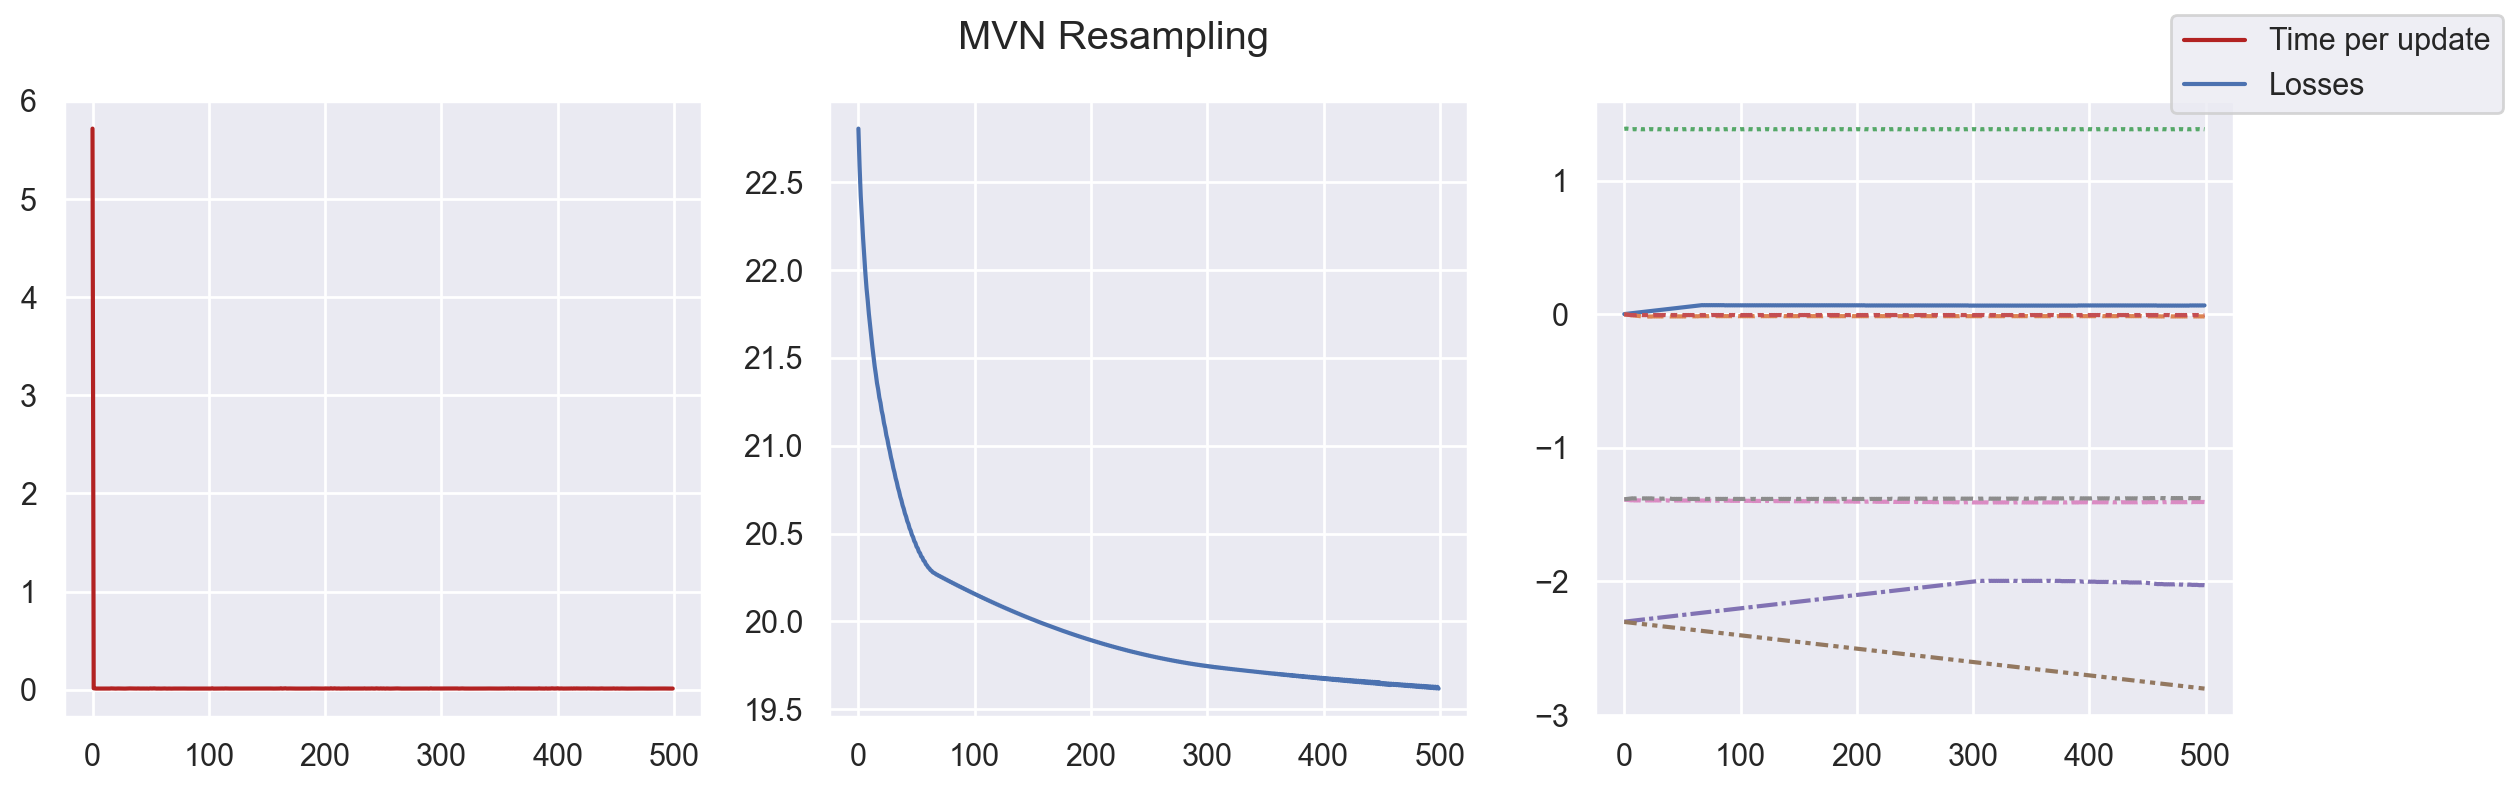

In [17]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(14, 4), sharey = False)
fig.suptitle("MVN Resampling")

ax[0].plot(np.arange(len(mvn_times)), mvn_times, color = "firebrick", label = "Time per update")
ax[1].plot(np.arange(len(mvn_times)), mvn_losses, label = "Losses")

sns.lineplot(pd.DataFrame(np.array(mvn_steps), columns = theta_names),
             ax=ax[2], legend = False)
fig.legend();

499
Is positive definite?:  True
Diag of inverse:  [2.49818430e-03 9.90907423e-04 1.02437284e-03 1.05688434e-03
 3.02627089e-01 2.27422337e+00 6.90492579e-03 5.89097387e-03]


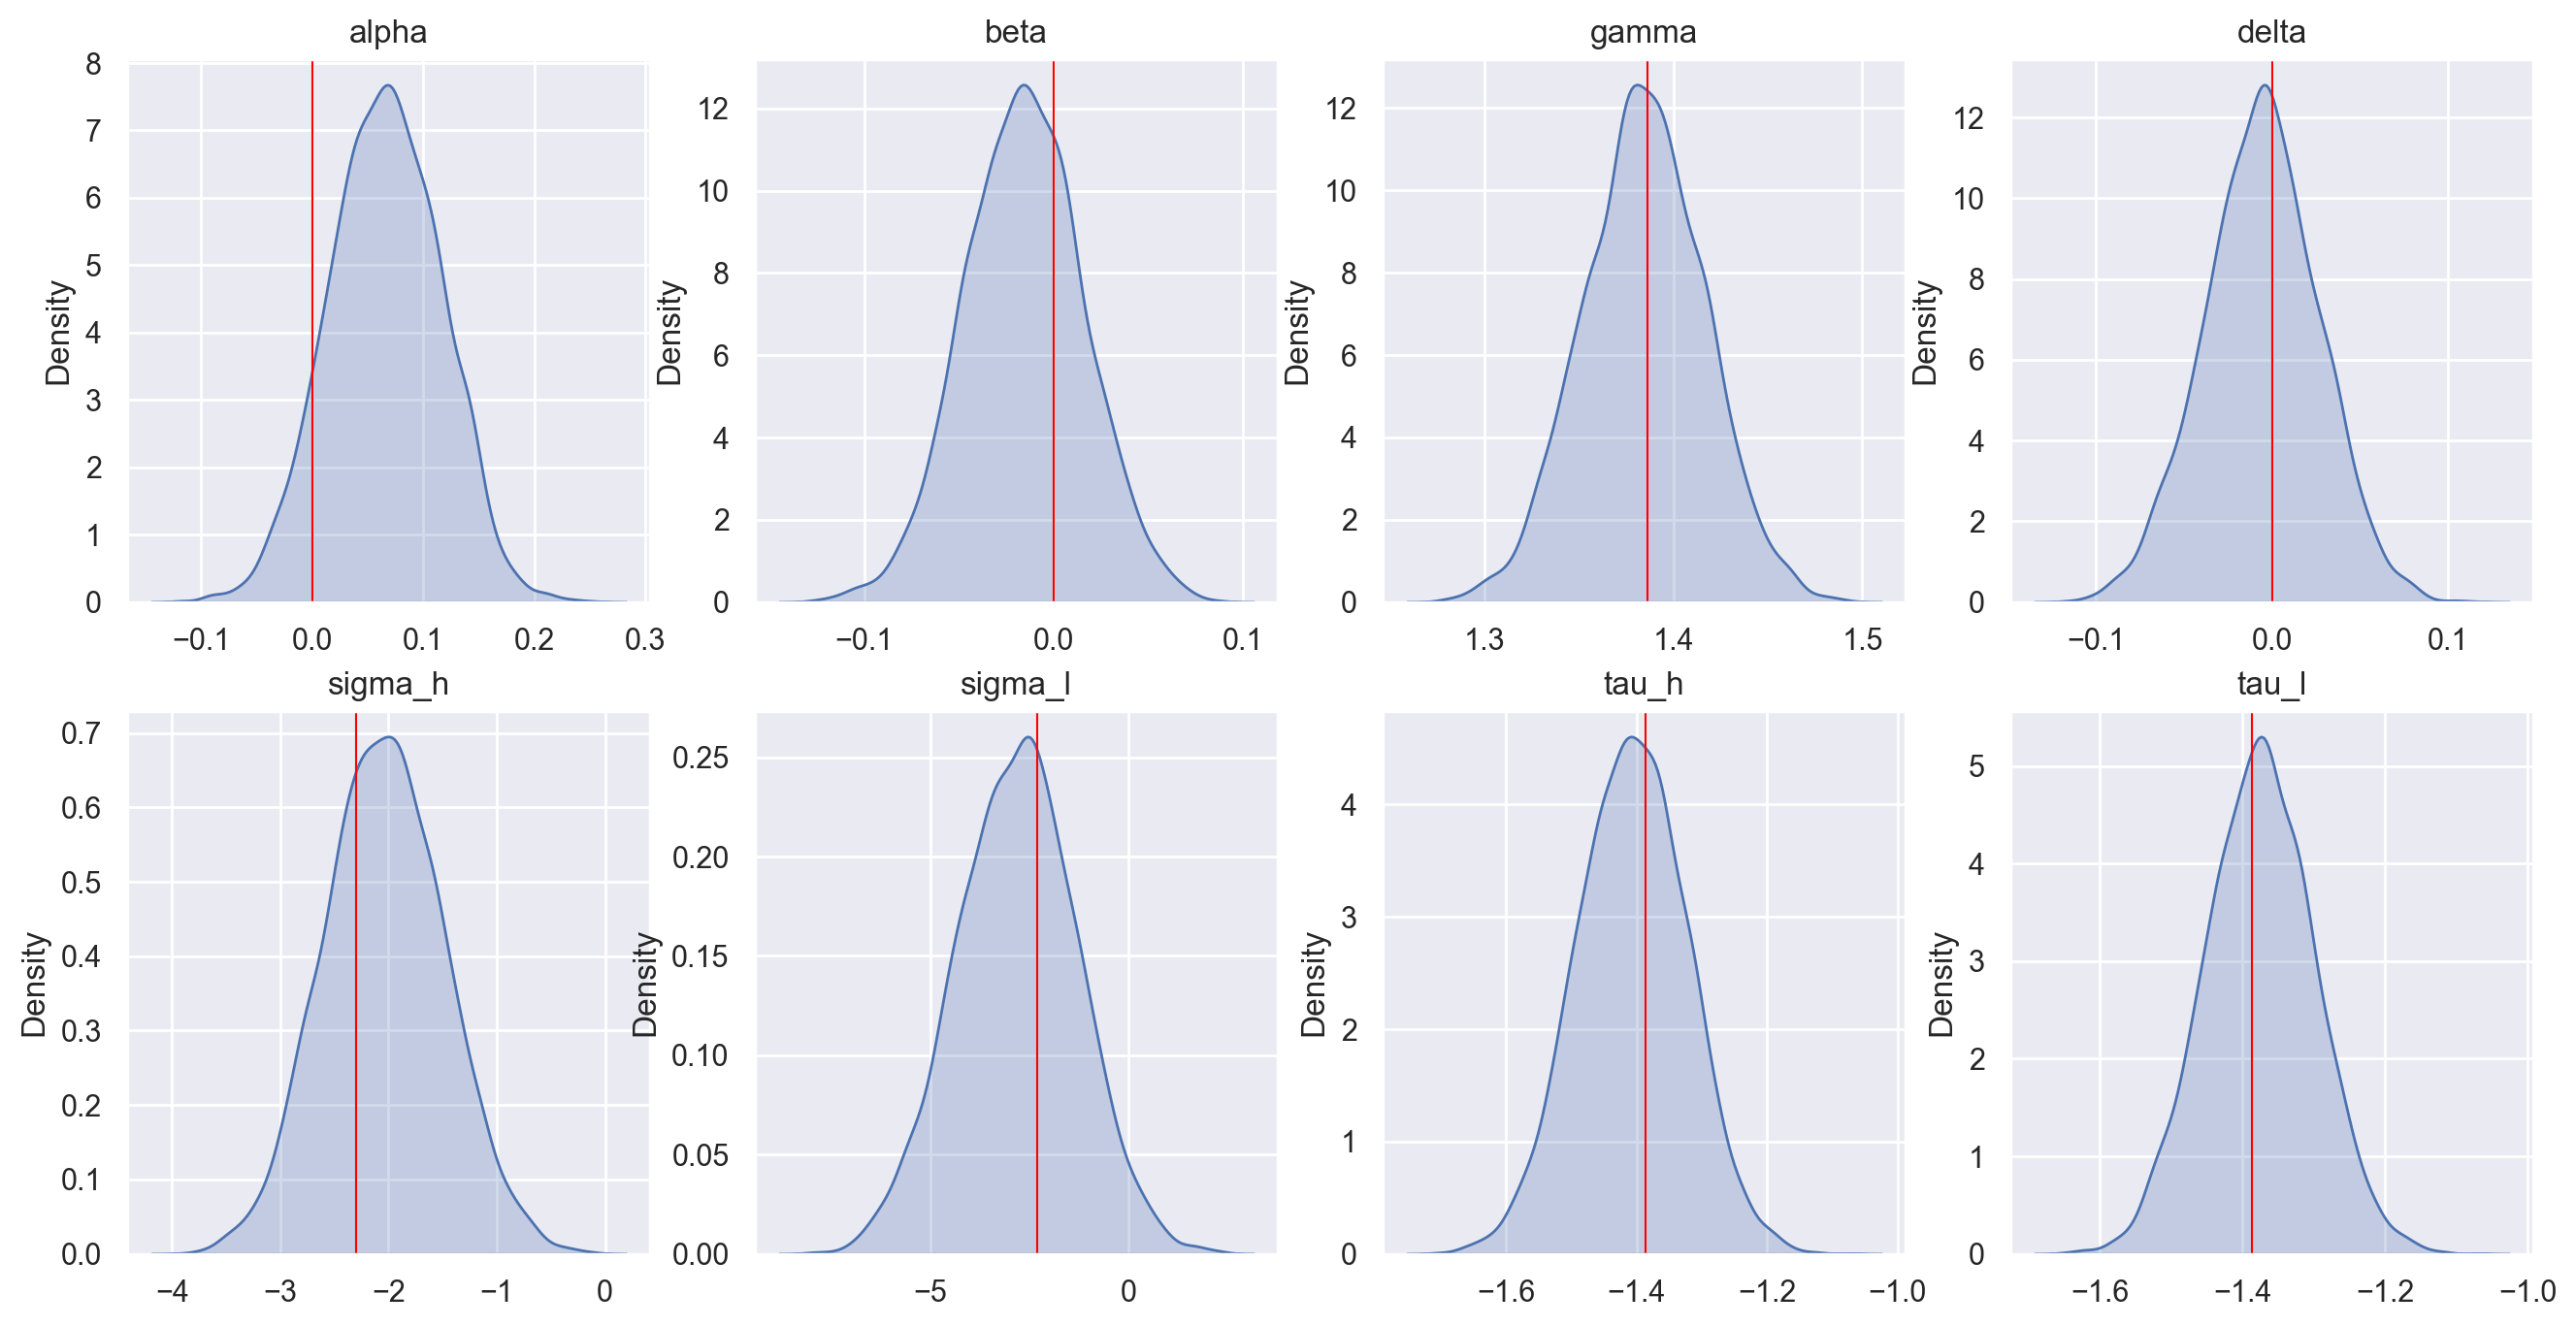

In [33]:
print(np.argmin(mvn_losses))

# check that we have minimized the negative log-lik: Hessian should be positive definite: 
mvn_hessian = jax.jacfwd(jax.jacrev(particle_neg_loglik_mvn))
hess = mvn_hessian(
    mvn_params,
    _key,
    n_particles=500,
    y_meas=y_meas,
    model=lotvol_model)

print("Is positive definite?: ", jnp.all(jnp.linalg.eigvals(hess) >= 0))
print("Diag of inverse: ", np.diag(jnp.linalg.inv(hess)))

var = jnp.linalg.inv(hess)
mle_samples = random.multivariate_normal(key=_key, mean=mvn_params, cov=var, shape=(5_000, ))

fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(16, 8))
for ind, _ax in enumerate(ax.flatten()):
    sns.kdeplot(mle_samples[:, ind], ax = _ax, shade = True).set_title(theta_names[ind])
    _ax.axvline(theta[ind], color='red', lw = 0.75)
plt.show();

Time:  202.31199407577515


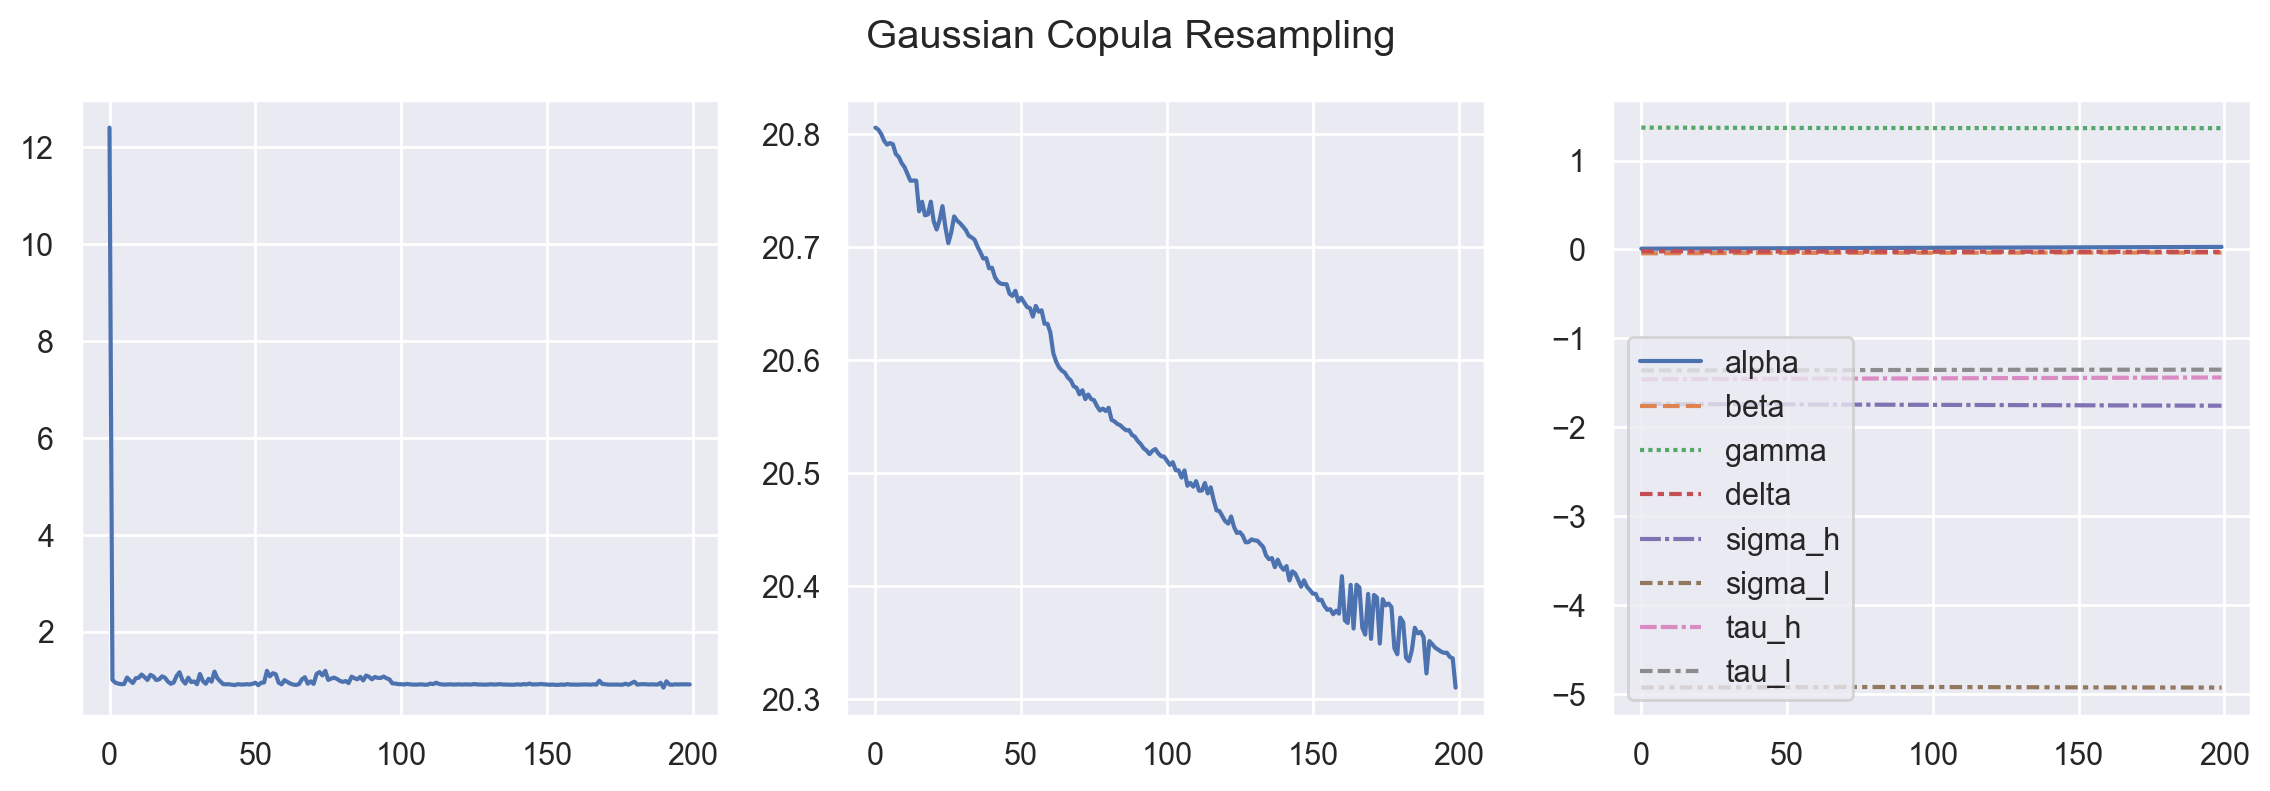

In [31]:
# Fix parameters and run both filters with these: 
n_particles = 500
n_iter = 200
learning_rate = 1e-4

start = time.time()
gc_params, gc_losses, gc_steps, gc_times = simple_grad_descent(
    subkey = _key,
    model = lotvol_model,
    grad_fun = particle_neg_loglik_gc,
    y_meas = y_meas,
    theta = gc_params, # Initialize with optimized multinomial
    learning_rate = learning_rate,
    n_iter = n_iter,
    n_particles = n_particles,
    mask=np.ones(len(theta))
)

print("Time: ", time.time() - start)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(14, 4), sharey = False)
fig.suptitle("Gaussian Copula Resampling")

ax[0].plot(np.arange(len(gc_times)), gc_times, label = "Time")
ax[1].plot(np.arange(len(gc_times)), gc_losses, label = "Losses")
sns.lineplot(pd.DataFrame(np.array(gc_steps), columns = theta_names),
             ax=ax[2], legend = True);

Is positive definite?:  False
Diag of inverse:  [-1.04985150e-03 -8.60804991e-05  7.11510822e-05  5.62060877e-05
  1.04498293e-02 -1.02270175e+01  2.18880855e-03 -8.69455457e-04]


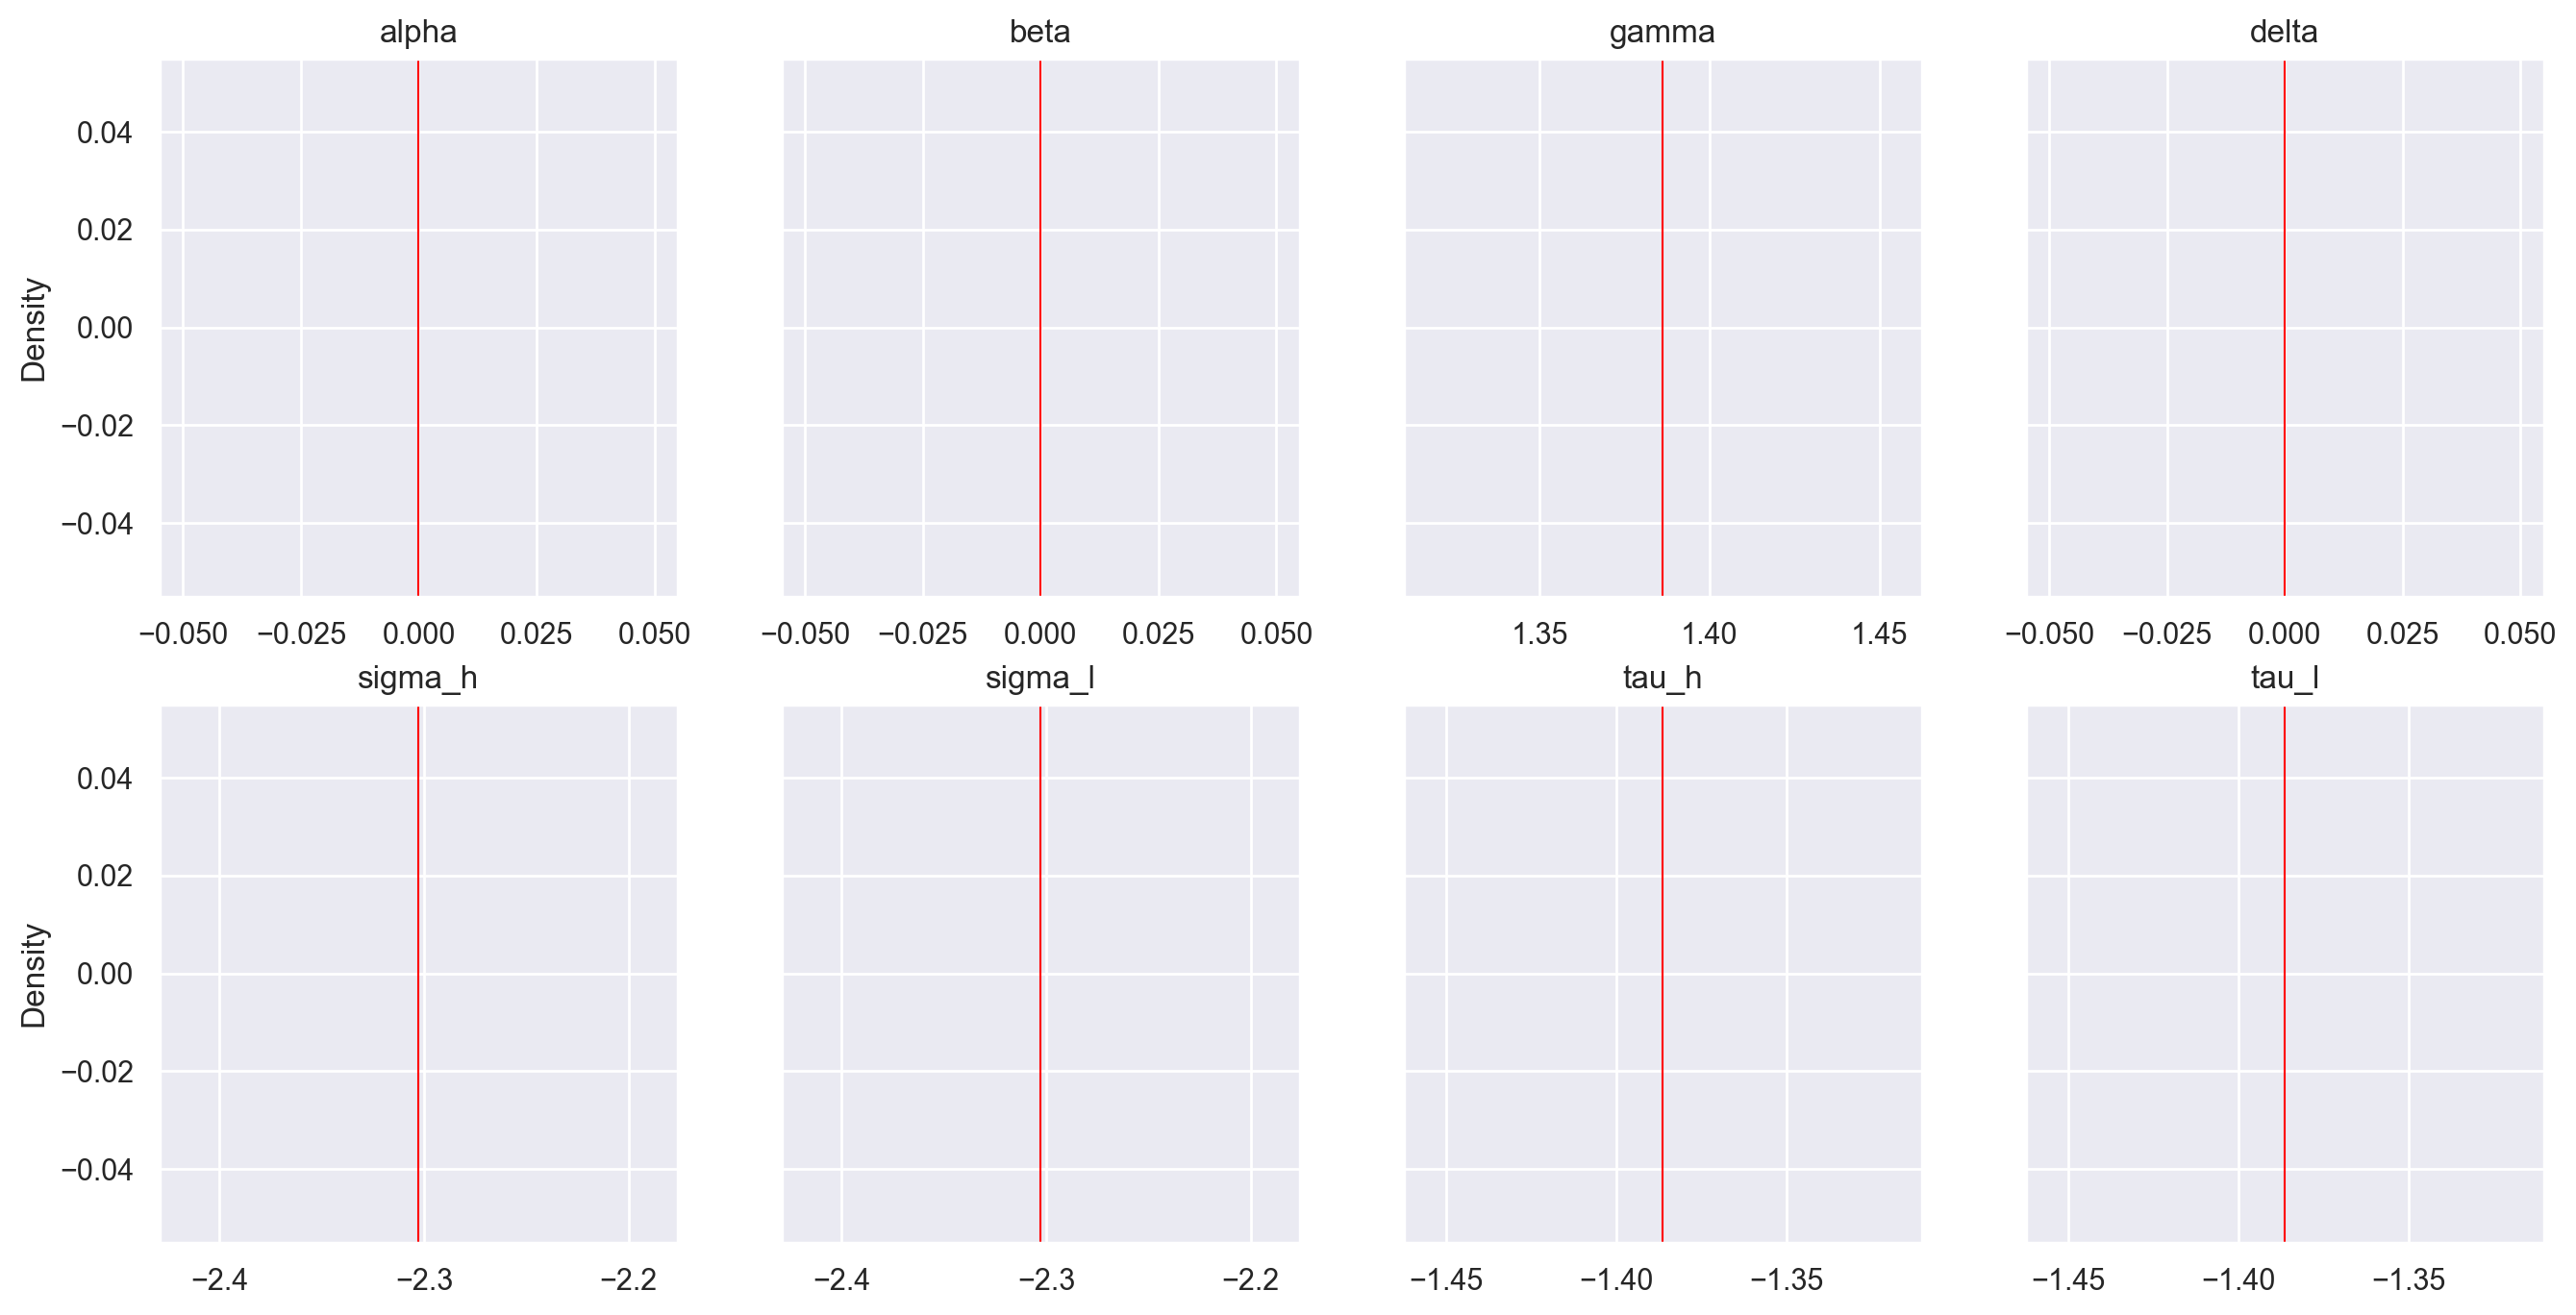

In [32]:
gc_hessian = jax.jacfwd(jax.jacrev(particle_neg_loglik_gc))
hess = gc_hessian(
    gc_params,
    _key,
    n_particles=n_particles,
    y_meas=y_meas,
    model=lotvol_model)

print("Is positive definite?: ", jnp.all(jnp.linalg.eigvals(hess) >= 0))
print("Diag of inverse: ", np.diag(jnp.linalg.inv(hess)))

var = jnp.linalg.inv(hess)
mle_samples = random.multivariate_normal(key=_key, mean=gc_params, cov=var, shape=(5_000, ))

fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(16, 8), sharey = True)
for ind, _ax in enumerate(ax.flatten()):
    sns.kdeplot(mle_samples[:, ind], ax = _ax, shade = True).set_title(theta_names[ind])
    _ax.axvline(theta[ind], color='red', lw = 0.75)
plt.show();

Time:  88.32075095176697
Estimated params:  [-2.00002350e-03 -3.59999848e-02  1.38029436e+00 -1.20000005e-02
 -1.72858508e+00 -4.93258534e+00 -1.47029425e+00 -1.37029437e+00]
True params:  [ 0.          0.          1.38629436  0.         -2.30258509 -2.30258509
 -1.38629436 -1.38629436]


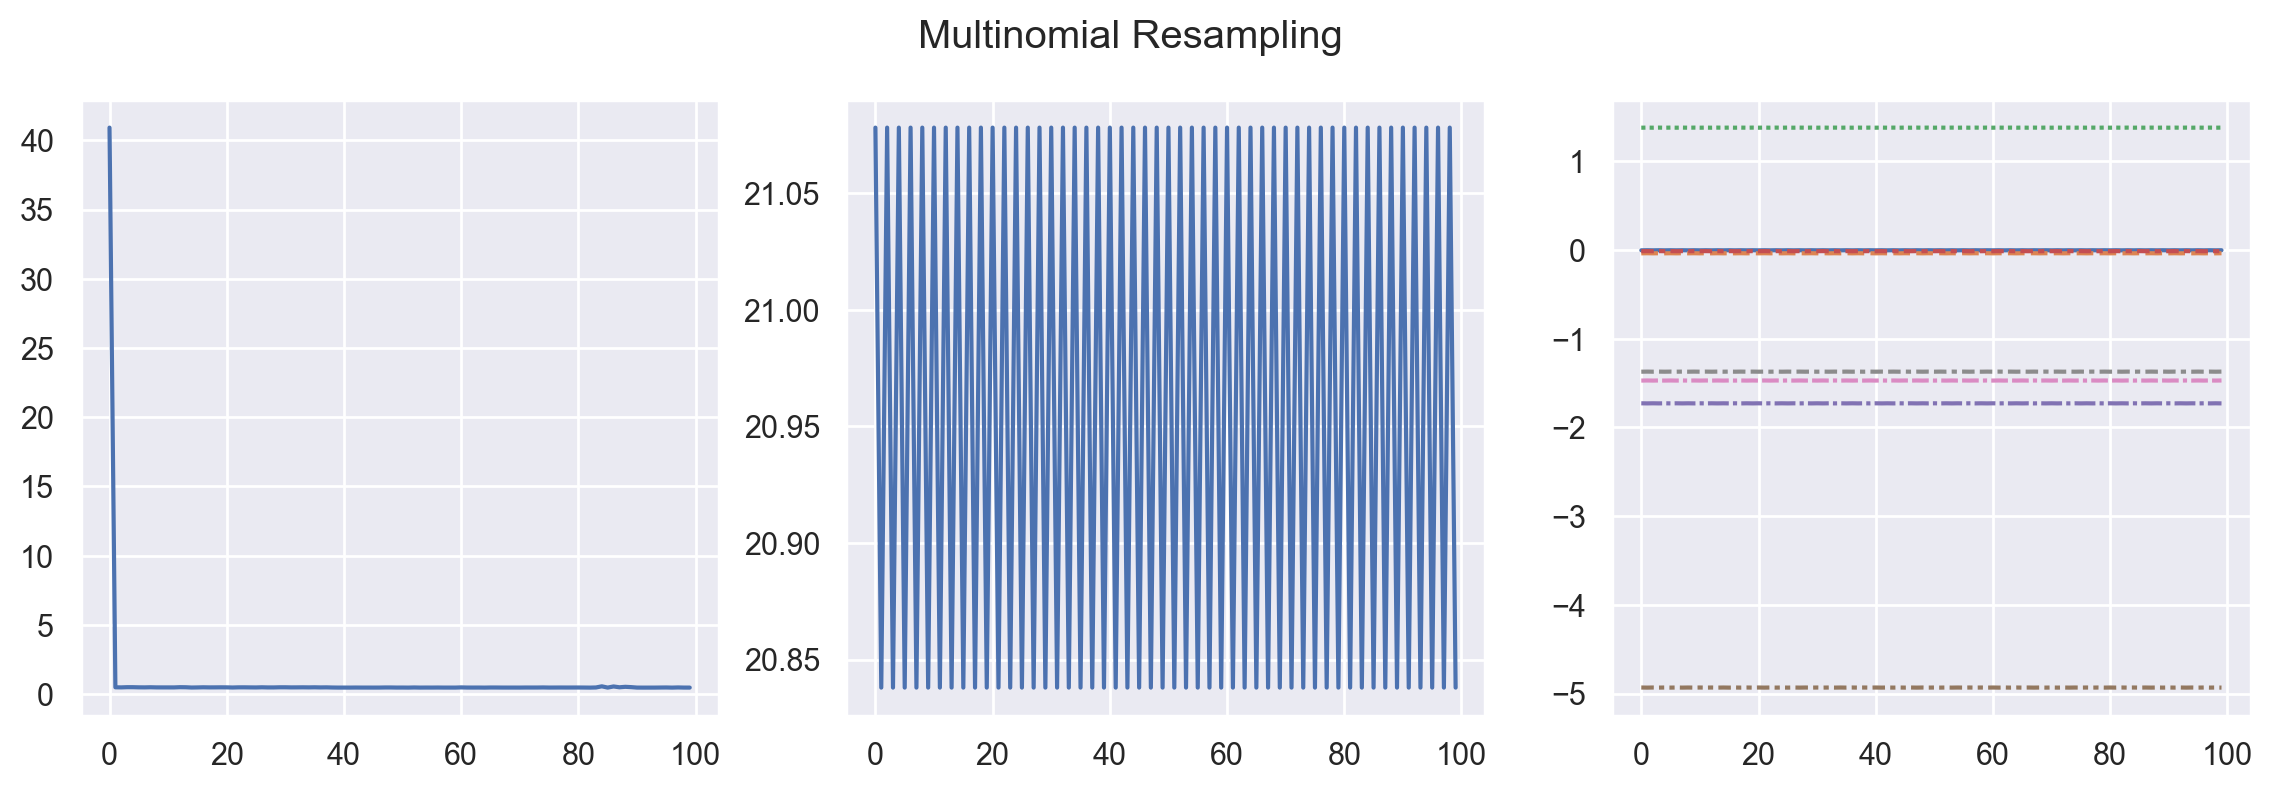

In [24]:
# Fix parameters and run both filters with these: 
n_particles = 10_000
n_iter = 100
learning_rate = 1e-3

start = time.time()
multinom_params, multinom_losses, multinom_steps, multinom_times = simple_grad_descent(
    subkey = _key,
    model = lotvol_model,
    grad_fun = particle_neg_loglik_bootstrap,
    y_meas = y_meas,
    theta = init_params,
    learning_rate = learning_rate,
    n_iter = n_iter,
    n_particles = n_particles,
    mask=np.ones(len(theta))
)

print("Time: ", time.time() - start)
print("Estimated params: ", multinom_params)
print("True params: ", theta)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(14, 4), sharey = False)
fig.suptitle("Multinomial Resampling")

ax[0].plot(np.arange(len(multinom_times)), multinom_times, label = "Time")
ax[1].plot(np.arange(len(multinom_times)), multinom_losses, label = "Losses")
sns.lineplot(pd.DataFrame(np.array(multinom_steps), columns = theta_names),
             ax=ax[2], legend = False);

99
Is positive definite?:  True


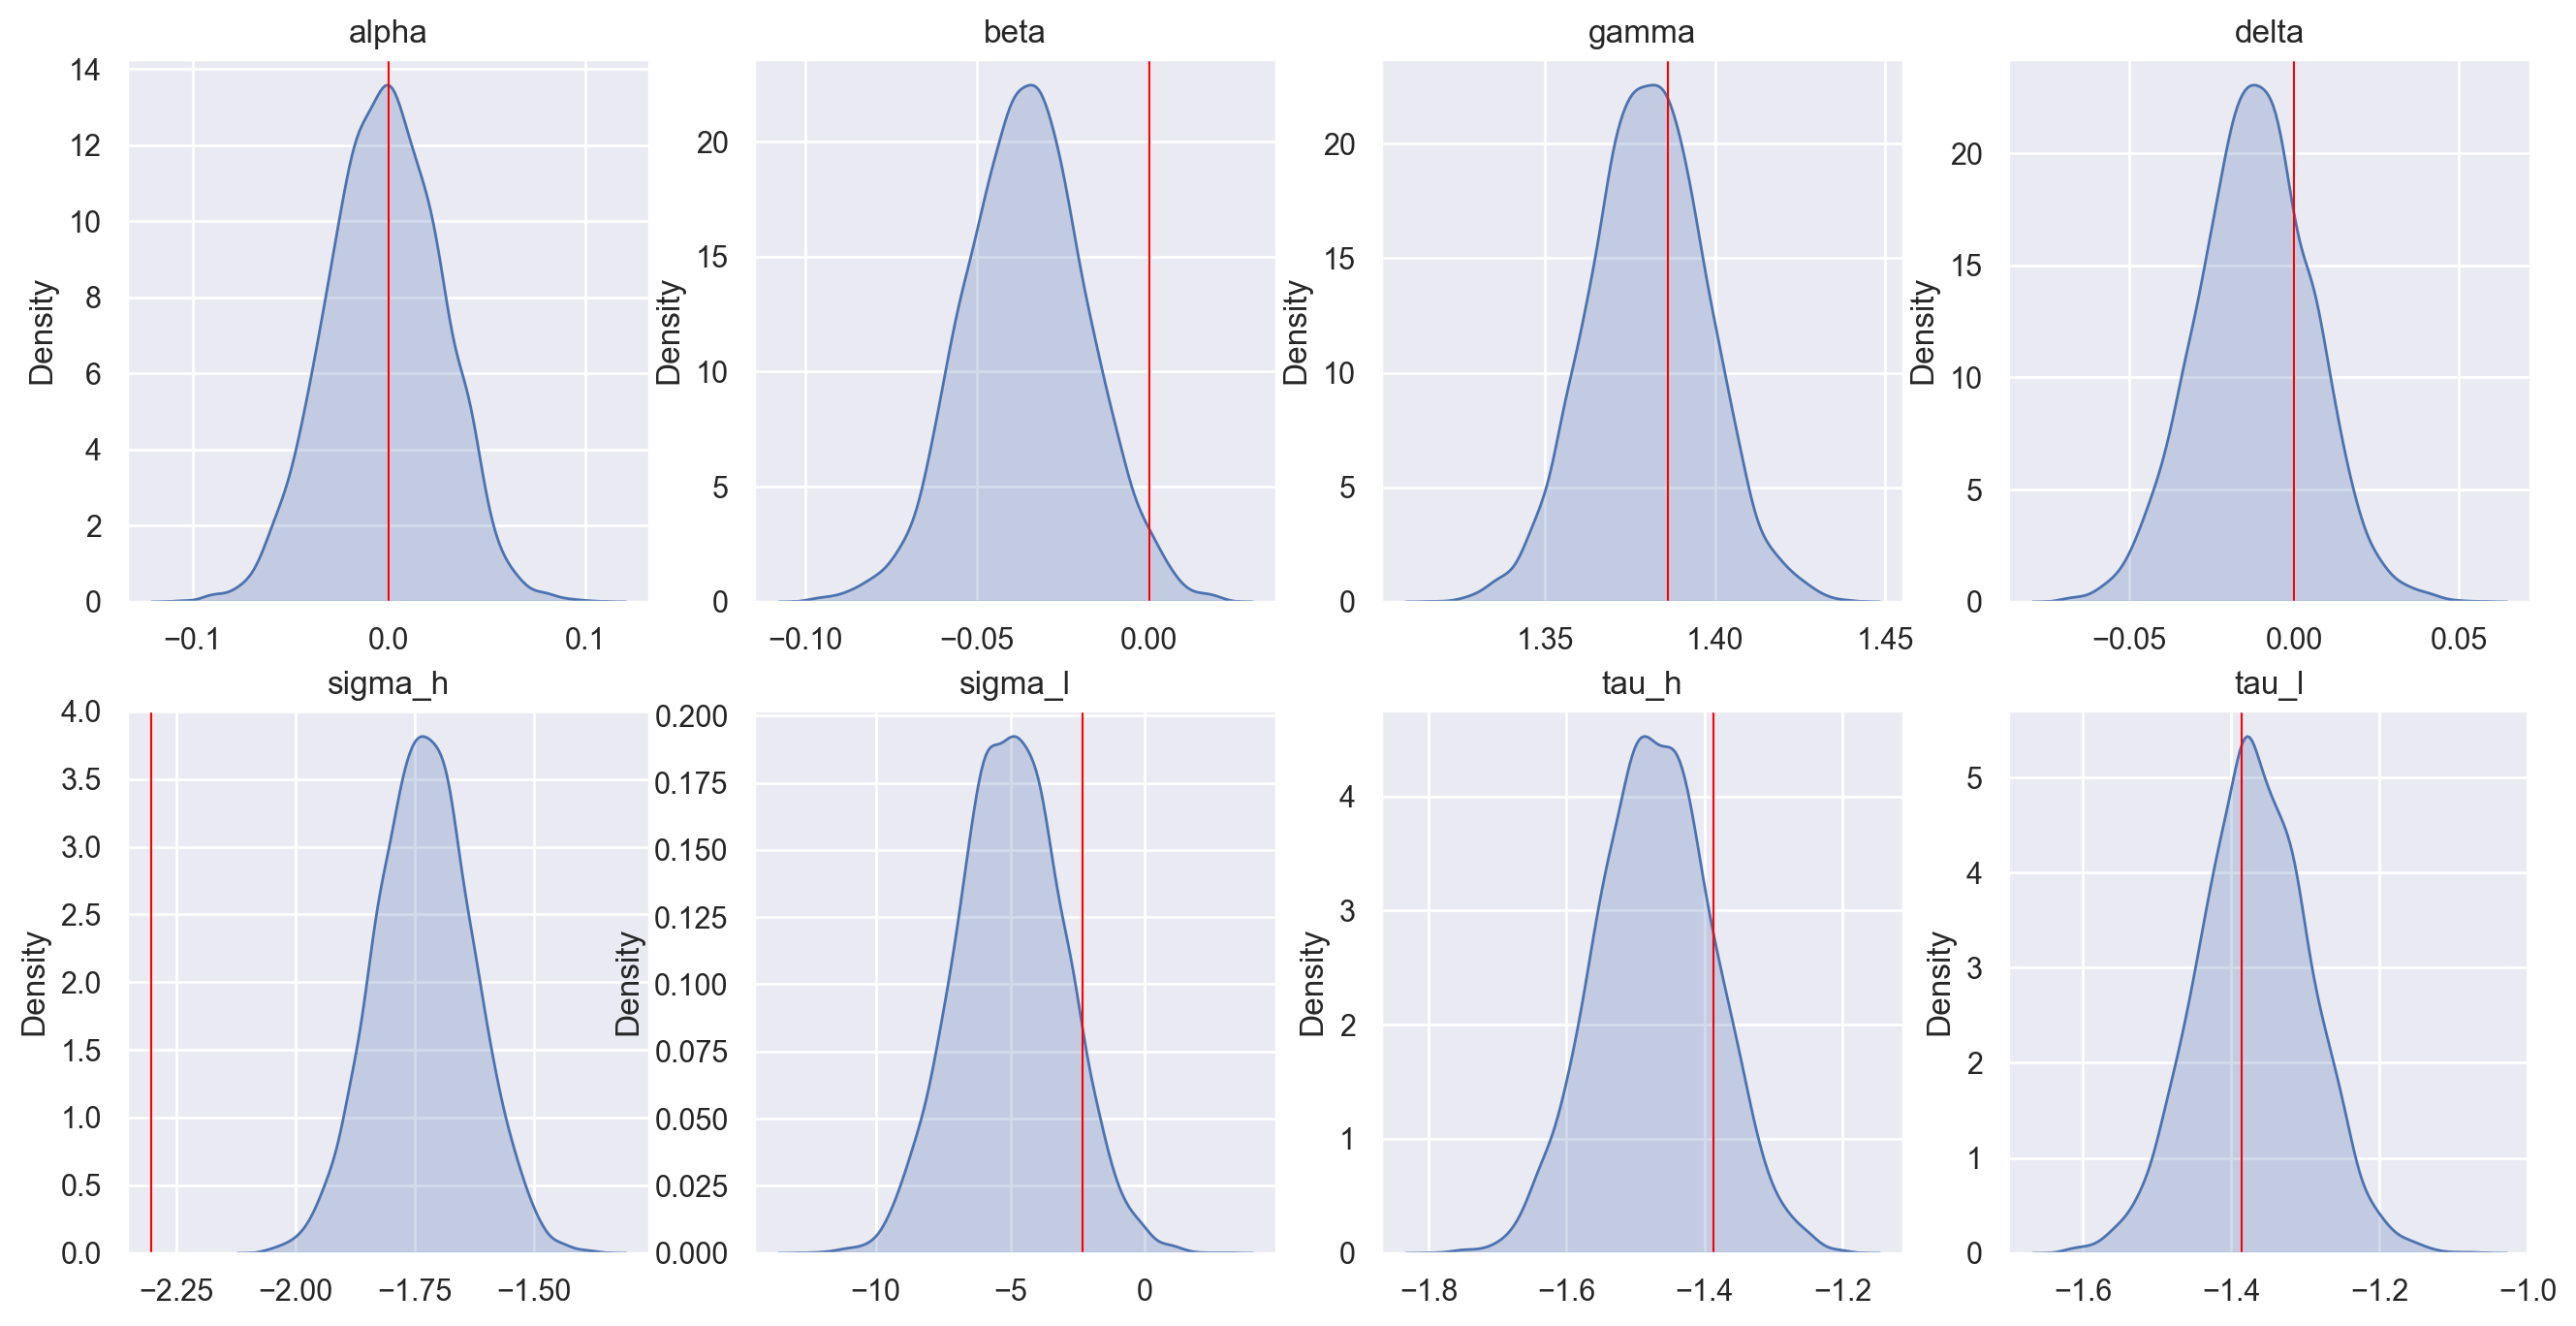

In [26]:
print(np.argmin(multinom_losses))
multinom_hessian = jax.jacfwd(jax.jacrev(particle_neg_loglik_bootstrap))
hess = multinom_hessian(
    multinom_params,
    _key,
    n_particles=1000,
    y_meas=y_meas,
    model=lotvol_model)

print("Is positive definite?: ", jnp.all(jnp.linalg.eigvals(hess) >= 0))

var = jnp.linalg.inv(hess)
mle_samples = random.multivariate_normal(key=_key, mean=multinom_params, cov=var, shape=(5_000, ))

fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(16, 8), sharey = False)
for ind, _ax in enumerate(ax.flatten()):
    sns.kdeplot(mle_samples[:, ind], ax = _ax, shade = True).set_title(theta_names[ind])
    _ax.axvline(theta[ind], color='red', lw = 0.75)
plt.show();

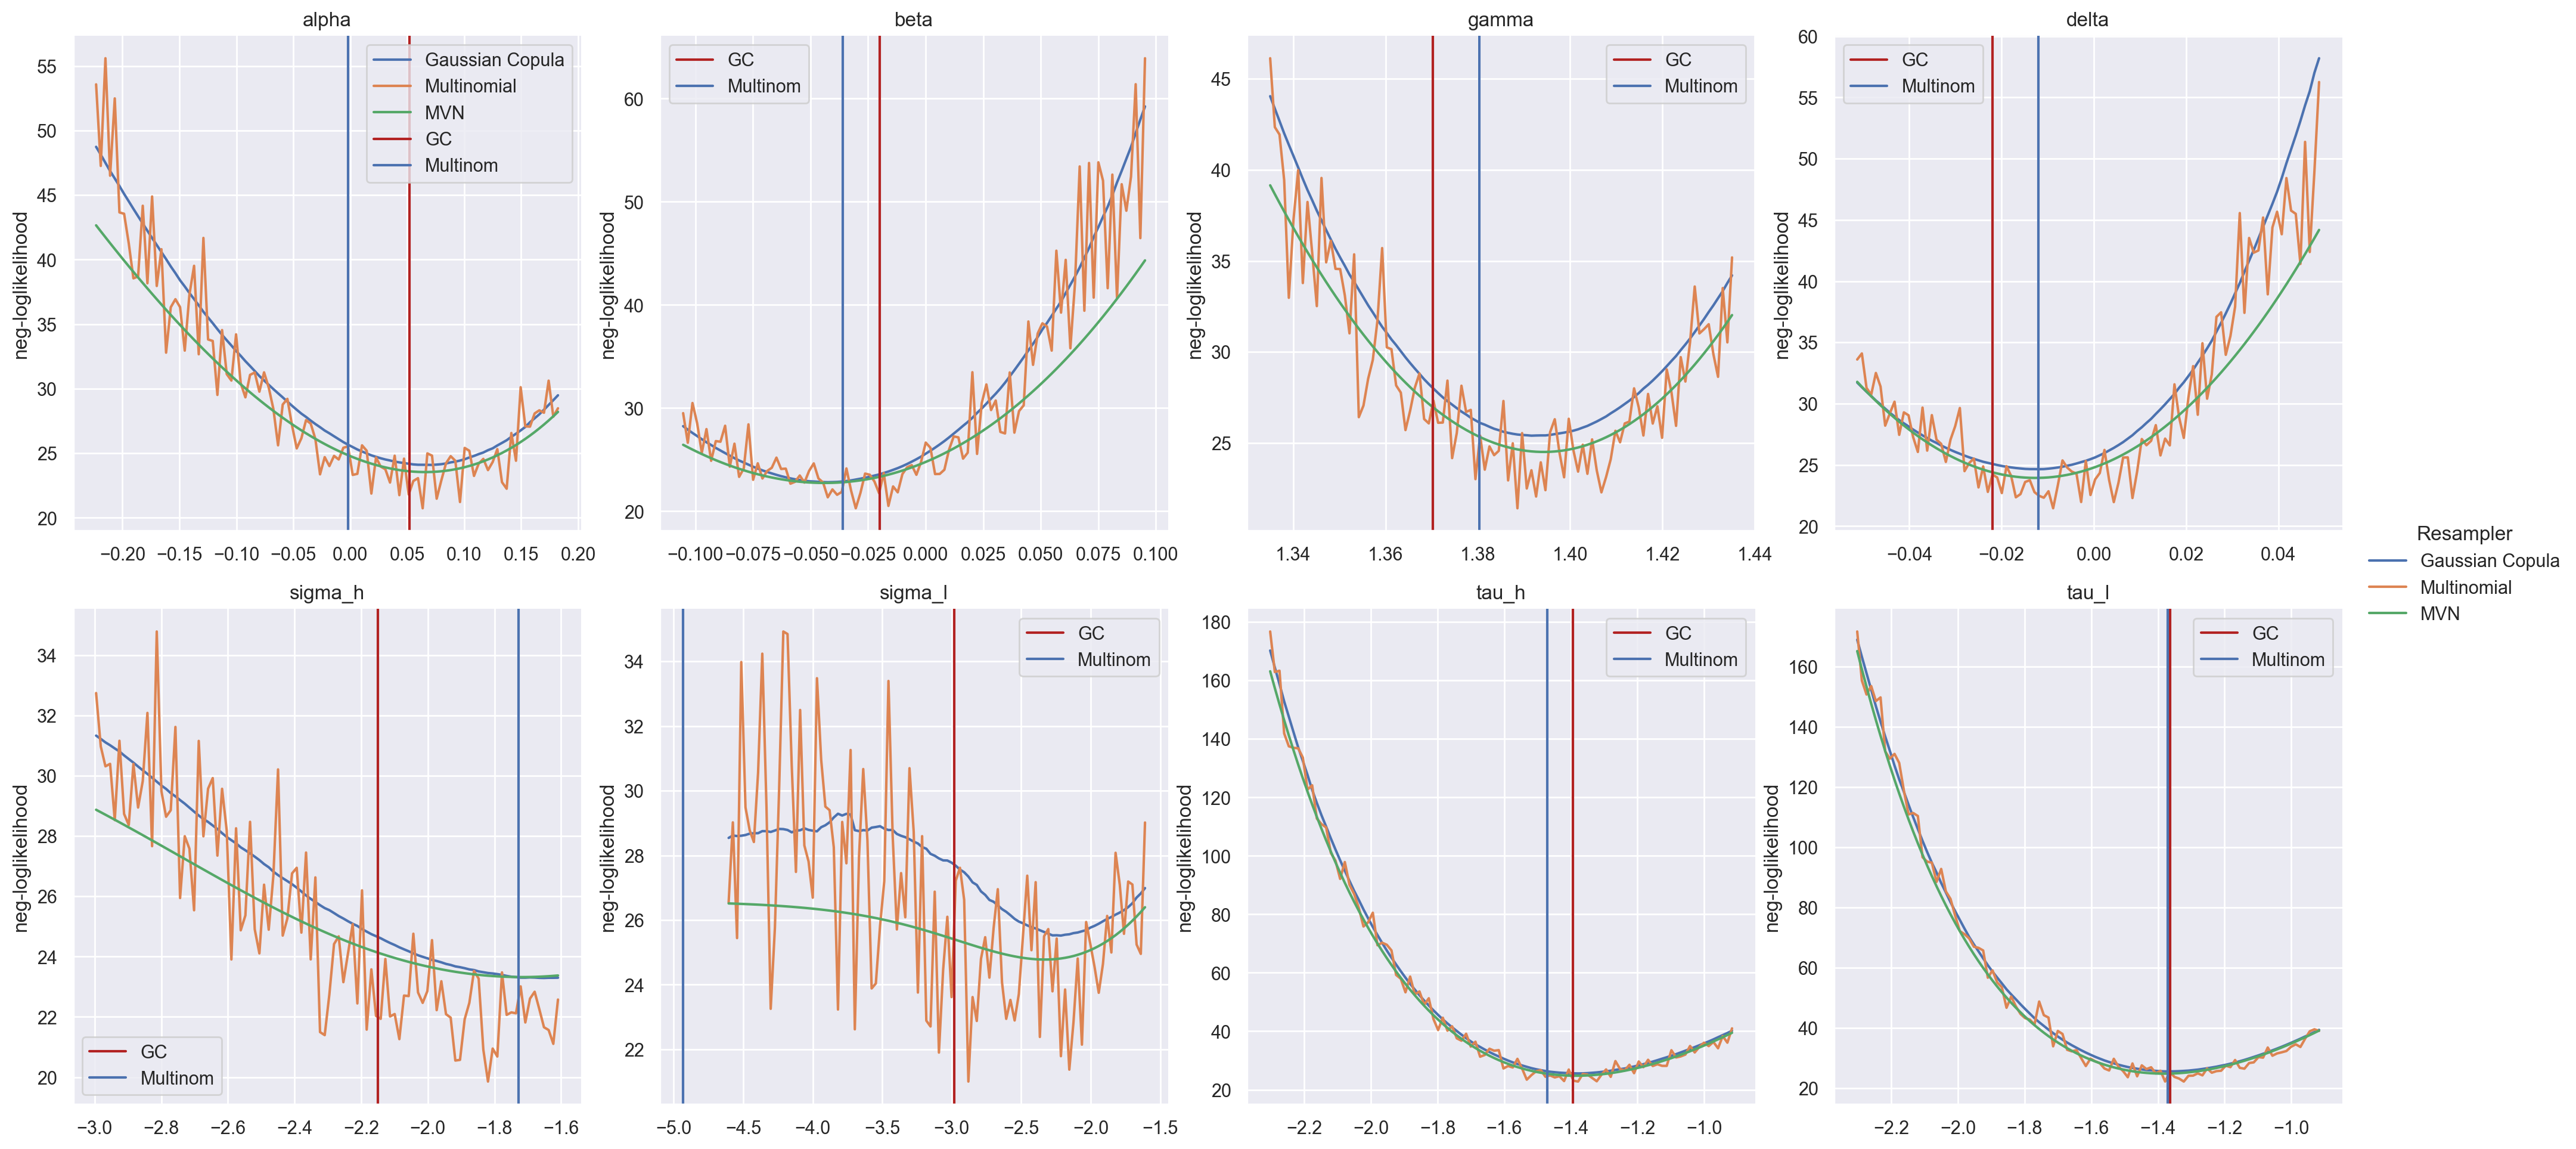

In [39]:
grid = sns.relplot(
    data=plot_df,
    kind="line",
    x="x", y="neg-loglikelihood", 
    hue="Resampler",
    col="x_opt",
    col_wrap = 4,
    facet_kws=dict(sharex=False, sharey=False)
)
grid.set_titles(col_template="{col_name}")
grid.set(xlabel=None)

for ind, _ax in enumerate(grid.axes.flat):
    _ax.axvline(gc_params[ind], color='firebrick', label="GC")
#     _ax.axvline(mvn_params[ind], color='black', label="MVN")
    _ax.axvline(multinom_params[ind], label="Multinom")
    _ax.legend();

## Change Seed

In [ ]:
# Fix parameters and run both filters with these: 
n_particles = 500
n_iter = 50
learning_rate = 1e-3

start = time.time()
gc_res = grad_descent_scan(
    key = _key,
    model = lotvol_model,
    grad_fun = particle_neg_loglik_gc,
    y_meas = y_meas,
    theta = init_params,
    learning_rate = learning_rate,
    n_iter = n_iter,
    n_particles = n_particles,
    mask=np.ones(len(theta))
)

print("Time: ", time.time() - start)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4), sharey = False)
fig.suptitle("Gaussian Copula Resampling")

ax[0].plot(np.arange(len(gc_res["losses"])), gc_res["losses"], label = "Losses")
sns.lineplot(pd.DataFrame(np.array(gc_res["steps"]), columns = theta_names),
             ax=ax[1], legend = True);

In [ ]:
gc_hessian = jax.jacfwd(jax.jacrev(particle_neg_loglik_gc))
hess = gc_hessian(
    gc_res["theta"],
    _key,
    n_particles=n_particles,
    y_meas=y_meas,
    model=lotvol_model)

print("Is positive definite?: ", jnp.all(jnp.linalg.eigvals(hess) >= 0))
print("Diag of inverse: ", np.diag(jnp.linalg.inv(hess)))

var = jnp.linalg.inv(hess)
mle_samples = random.multivariate_normal(key=_key, mean=gc_res["theta"], cov=var, shape=(5_000, ))

fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(16, 8), sharey = True)
for ind, _ax in enumerate(ax.flatten()):
    sns.kdeplot(mle_samples[:, ind], ax = _ax, shade = True).set_title(theta_names[ind])
    _ax.axvline(theta[ind], color='red', lw = 0.75)
plt.show();

In [ ]:
# Fix parameters and run both filters with these: 
n_particles = 10_000
n_iter = 5_000
learning_rate = 1e-3

start = time.time()
multinom_res = grad_descent_scan(
    key = _key,
    model = lotvol_model,
    grad_fun = particle_neg_loglik_bootstrap,
    y_meas = y_meas,
    theta = init_params,
    learning_rate = learning_rate,
    n_iter = n_iter,
    n_particles = n_particles,
    mask=np.ones(len(theta))
)

print("Time: ", time.time() - start)
print("Estimated params: ", multinom_res["theta"])
print("True params: ", theta)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 4), sharey = False)
fig.suptitle("Multinomial Resampling")
ax[0].plot(np.arange(len(multinom_res["losses"])), multinom_res["losses"], label = "Losses")
sns.lineplot(pd.DataFrame(np.array(multinom_res["steps"]), columns = theta_names),
             ax=ax[1], legend = False);

In [ ]:
multinom_hessian = jax.jacfwd(jax.jacrev(particle_neg_loglik_bootstrap))
hess = multinom_hessian(
    multinom_res["theta"],
    _subkey,
    n_particles=n_particles,
    y_meas=y_meas,
    model=lotvol_model)

print("Is positive definite?: ", jnp.all(jnp.linalg.eigvals(hess) >= 0))

var = jnp.linalg.inv(hess)
mle_samples = random.multivariate_normal(key=_key, mean=multinom_res["theta"], cov=var, shape=(5_000, ))

fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(16, 8), sharey = True)
for ind, _ax in enumerate(ax.flatten()):
    sns.kdeplot(mle_samples[:, ind], ax = _ax, shade = True).set_title(theta_names[ind])
    _ax.axvline(theta[ind], color='red', lw = 0.75)
plt.show();

## Work-Precision Plots

- Benchmark: Take true params and 5k particles (lots of particles)
- Run basic pf with a diff number of particles with diff seeds each time
- Evaluate the log-lik on each of these particles 100 times each (multiple times each)
- Record the runtime per random seed, for each of the number of particles
- Calculate RMSE for each of the true params and estimated params for each # of particles
- Plot (clock time VS accuracy) for each method. Doesn't have to be the same number of particle for each method, 

In [ ]:
import tqdm

In [ ]:
def run_sim_for (loglik, num_particles, true_params, init_params, n_iters, learning_rates, num_sim=10):
    times = np.zeros((len(num_particles), num_sim))
    mse = np.zeros((len(num_particles), num_sim))
    key = random.PRNGKey(0)
    
    for i in range(len(num_particles)): 
        print("Iteration: ", i)
        
        for j in range(num_sim):
            key, subkey = random.split(key)
            start = time.perf_counter()
            if j % 5 == 0:
                print("   Inner iter: ", j)
            _params, _losses, _steps, _time = simple_grad_descent2(
                subkey = subkey,
                model = lotvol_model,
                grad_fun = loglik,
                y_meas = y_meas,
                theta = init_params,
                learning_rate = learning_rates[i],
                n_iter = n_iters[i],
                n_particles = num_particles[i],
                mask=jnp.ones(len(init_params))
            )
            times[i, j] = time.perf_counter() - start # work measured in clock time
            mse[i, j] = sum((_params - true_params)**2) # MSE of estimates
            
    return times, mse, num_particles


def run_sim (loglik, num_particles, true_params, init_params, n_iters, learning_rates, num_sim=10):
    times = np.zeros(len(num_particles))
    mse = np.zeros(len(num_particles))
    key = random.PRNGKey(10)
    results = []
    for i in tqdm.tqdm(range(len(num_particles))): 
        key, *subkeys = random.split(key, num_sim+1)
        start = time.perf_counter()
        sim_res = jax.vmap(lambda key, lr, n_iter, n_part:
             grad_descent_scan(
                 key = key,
                 model = lotvol_model,
                 grad_fun = loglik,
                 y_meas = y_meas,
                 theta = init_params,
                 learning_rate = lr,
                 n_iter = n_iter,
                 n_particles = n_part,
                 mask=jnp.ones(len(init_params))),
             in_axes = (0, None, None, None))(jnp.array(subkeys), learning_rates[i], n_iters[i], num_particles[i])
        end = time.perf_counter()
        mse[i] = (jnp.mean((sim_res["theta"] - true_params)**2)) # MSE averaged over runs
        times[i] = ((end - start)/num_sim) # average times
        results.append(sim_res)
    return times, mse, num_particles, results

In [ ]:
multinom_particles = [50, 100, 250, 500, 1000]
multinom_times, multinom_mse, multinom_num_particles, multinom_results = run_sim(
    loglik = particle_neg_loglik_bootstrap,
    num_particles = multinom_particles,
    true_params = theta,
    init_params = init_params,
    n_iters = [500, 500, 500, 500, 500],
    learning_rates = [1e-3, 1e-3, 1e-3, 1e-3, 1e-3])

In [ ]:
gc_particles = [10, 25, 50, 100]
gc_times, gc_mse, gc_num_particles, gc_results = run_sim(
    loglik = particle_neg_loglik_gc,
    num_particles = gc_particles,
    true_params = theta,
    init_params = init_params,
    n_iters = [500, 500, 500, 500, 500],
    learning_rates = [1e-3, 1e-3, 1e-3, 1e-3, 1e-3])

In [ ]:
mvn_particles = [50, 100, 250, 500, 1000]
mvn_times, mvn_mse, mvn_num_particles, mvn_results = run_sim(
    loglik = particle_neg_loglik_mvn,
    num_particles = mvn_particles,
    true_params = theta,
    init_params = init_params,
    n_iters = [500, 500, 500, 500, 500],
    learning_rates = [1e-3, 1e-3, 1e-3, 1e-3, 1e-3])

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(14, 4), sharey = False)

ax[0].plot(mvn_times, mvn_mse, label = "MVN")
ax[0].plot(gc_times, gc_mse, label = "GC")
ax[0].plot(multinom_times, multinom_mse, label = "Multinomial")
ax[0].set(title="MSE VS Runtime")
ax[0].legend()

ax[1].plot(multinom_particles, mvn_times,  label = "MVN Resampling")
ax[1].plot(gc_particles, gc_times,  label = "GC Resampling")
ax[1].plot(mvn_particles, multinom_times,  label = "Multinomial Resampling")
ax[1].set(title="Number of Particles VS Runtime")
ax[1].legend()

ax[2].plot(list(map(lambda x: np.min(x["losses"]), mvn_results)), label = "MVNN")
ax[2].plot(list(map(lambda x: np.min(x["losses"]), gc_results)), label = "GC")
ax[2].plot(list(map(lambda x: np.min(x["losses"]), multinom_results)), label = "Multinomial");
ax[2].set(title="Min losses after Gradient Descent")
ax[2].legend();

In [ ]:
## EXPERIMENT: MSE VS number of particles for MVN: 
mvn_particles = np.arange(75, 500, step = 75)
mvn_times, mvn_mse, mvn_num_particles, mvn_results = run_sim(
    loglik = particle_neg_loglik_mvn,
    num_particles = mvn_particles,
    true_params = theta,
    init_params = init_params,
#     n_iters = [500] * len(mvn_particles),
    n_iters = [500, 750, 1000, 1200, 1500, 2000],
    learning_rates = [1e-3] * len(mvn_particles),
    num_sim=100)

multinom_particles = np.arange(75, 500, step = 75)
multinom_times, multinom_mse, multinom_num_particles, multinom_results = run_sim(
    loglik = particle_neg_loglik_bootstrap,
    num_particles = multinom_particles,
    true_params = theta,
    init_params = init_params,
#     n_iters = [500] * len(multinom_particles),
    n_iters = [500, 750, 1000, 1200, 1500, 2000],
    learning_rates = [1e-3] * len(multinom_particles),
    num_sim = 100)

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 4), sharey = True)

ax[0].plot(mvn_particles, mvn_mse, label = "MVN")
ax[1].plot(multinom_particles, multinom_mse, label = "multinom")
plt.legend();

### Findings and Questions

- As the number of particles increases, the minimum loss from optimization also increases. Why would this happen? Shouldn't it be around the same value? 
- Not much of an improvement in the MSE when we increase the number of particles

- **Q:** Should we use a constant seed for gradient descent? 


# Brownian Motion Model

In [ ]:
from pfjax.models import BMModel

# initial key for random numbers
key = random.PRNGKey(0)
sns.set_style("darkgrid")
# parameter values
mu = 5.
sigma = .2
tau = 1.
theta_true = jnp.array([mu, sigma, tau])
bm_theta_names = ["mu", "sigma", "tau"]

# data specification
dt = .2
n_obs = 100
x_init = jnp.array(0.)

# simulate data
bm_model = BMModel(dt=dt)
key, subkey = random.split(key)
y_meas, x_state = pf.simulate(bm_model, subkey, n_obs, x_init, theta_true)

# plot data
plot_df = (pd.DataFrame({"time": jnp.arange(n_obs) * dt,
                         "x_state": jnp.squeeze(x_state),
                         "y_meas": jnp.squeeze(y_meas)})
           .melt(id_vars="time", var_name="type"))
sns.relplot(
    data=plot_df, kind="line",
    x="time", y="value", hue="type"
)
plt.title("Latent Variable(x_state) and Observation(y_meas)");

In [ ]:
bm_theta_lims = jnp.array([
    [4.8, 5.2],
    [0.1, .3],
    [0.9, 1.1]])

In [ ]:
@partial(jax.jit, static_argnums=(2,))
def bm_neg_loglik_mvn(theta, key, n_particles=500):
    """ negative log-likelihood of PF with MVN resampling """
    ret = pf.particle_filter(
        theta=theta, 
        model=bm_model, 
        y_meas=y_meas, 
        n_particles=n_particles, 
        key=key,
        resampler = resampler.resample_mvn)
    return -ret["loglik"]


@partial(jax.jit, static_argnums=(2,))
def bm_neg_loglik_gc(theta, key, n_particles=250):
    """ negative log-likelihood of PF with GC resampling """
    ret = pf.particle_filter(
        theta=theta, 
        model=bm_model, 
        y_meas=y_meas, 
        n_particles=n_particles, 
        key=key,
        resampler = resampler.resample_gaussian_copula)
    return -ret["loglik"]


@partial(jax.jit, static_argnums=(2,))
def bm_neg_loglik_bootstrap(theta, key, n_particles=500):
    """ negative log-likelihood of PF with multinomial resampling """
    ret = pf.particle_filter(
        theta=theta, 
        model=bm_model, 
        y_meas=y_meas, 
        n_particles=n_particles, 
        key=key)
    return -ret["loglik"]

In [ ]:
# calculate projection plot for exact loglikelihood
df_gc = pjp.proj_plot(
    fun = lambda x: bm_neg_loglik_gc(x, key=_key, n_particles=50), 
    x_opt=theta_true, 
    x_lims=bm_theta_lims, 
    x_names=bm_theta_names, 
    n_pts=300,
    plot=False
)


# calculate projection plot for exact loglikelihood
df_mvn = pjp.proj_plot(
    fun = lambda x: bm_neg_loglik_mvn(x, key=_key, n_particles=50), 
    x_opt=theta_true, 
    x_lims=bm_theta_lims, 
    x_names=bm_theta_names, 
    n_pts=300,
    plot=False
)

# calculate projection plot for particle filter loglikelihood
df_multinom = pjp.proj_plot(
    fun=lambda x: bm_neg_loglik_bootstrap(x, key=_key, n_particles=50),
    x_opt=theta_true, 
    x_lims=bm_theta_lims, 
    x_names=bm_theta_names, 
    n_pts=300,
    plot=False
)

In [ ]:
# merge data frames and plot them
plot_df = pd.concat([df_gc, df_multinom, df_mvn], ignore_index=True)
plot_df["Resampler"] = np.repeat(["Gaussian Copula", "Multinomial", "MVN"], len(df_gc["x_opt"]))
plot_df = plot_df.rename(columns={"y": "neg-loglikelihood"})

grid = sns.relplot(
    data=plot_df, kind="line",
    x="x", y="neg-loglikelihood", 
    hue="Resampler",
    col="x_opt",
    col_wrap = 4,
    facet_kws=dict(sharex=False, sharey=False)
)
grid.set_titles(col_template="{col_name}")
grid.set(xlabel=None)

for ind, _ax in enumerate(grid.axes.flat):
    _ax.axvline(theta[ind], color='red', lw = 0.9, label="True")
    _ax.legend();

# References

(<a id="cit-corenflos_etal21" href="#call-corenflos_etal21">Corenflos, Thornton <em>et al.</em>, 2021</a>) A. Corenflos, J. Thornton, G. Deligiannidis <em>et al.</em>, ``_Differentiable particle filtering via entropy-regularized optimal transport_'', Proceedings of the 38th international conference on machine learning, July 2021.  [online](https://proceedings.mlr.press/v139/corenflos21a.html)

(<a id="cit-cappe_moulines05" href="#call-cappe_moulines05">Cappé and Moulines, 2005</a>) O. Cappé and E. Moulines, ``_On the use of particle filtering for maximum likelihood parameter estimation_'', 13th European Signal Processing Conference,  2005.

(<a id="cit-poyiadjis_etal11" href="#call-poyiadjis_etal11">Poyiadjis, Doucet <em>et al.</em>, 2011</a>) Poyiadjis G., Doucet A. and Singh S. S., ``_Particle approximations of the score and observed information matrix in state space models with application to parameter estimation_'', Biometrika, vol. 98, number 1, pp. 65--80,  2011.  [online](https://academic.oup.com/biomet/article-lookup/doi/10.1093/biomet/asq062)

